NASA’s Fire Information for Resource Management System (FIRMS) (Link) – Global wildfire occurrences.
Global Fire Emissions Database (GFED) (Link) – Fire emissions and burned areas.
NOAA National Centers for Environmental Information (NCEI) (Link – Climate and temperature data.
Berkeley Earth Global Temperature Dataset (Link) – Historical global temperature records.
We'll use the NASA FIRMS dataset (wildfire occurrences) and combine it with the Berkeley Earth temperature dataset for analysis.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import requests
import io


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/188-million-us-wildfires")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2


In [ ]:
import os

# Define dataset directory
dataset_dir = "/root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/"

# List all files in the directory
print("Files in dataset directory:", os.listdir(dataset_dir))


Files in dataset directory: ['FPA_FOD_20170508.sqlite']


In [ ]:
import sqlite3
import pandas as pd

# Define the database path
db_path = "/root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Get a list of all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Show available tables
print("Tables in the database:")
print(tables)


Tables in the database:
                                  name
0                      spatial_ref_sys
1                   spatialite_history
2                      sqlite_sequence
3                     geometry_columns
4                  spatial_ref_sys_aux
5               views_geometry_columns
6               virts_geometry_columns
7          geometry_columns_statistics
8    views_geometry_columns_statistics
9    virts_geometry_columns_statistics
10        geometry_columns_field_infos
11  views_geometry_columns_field_infos
12  virts_geometry_columns_field_infos
13               geometry_columns_time
14               geometry_columns_auth
15         views_geometry_columns_auth
16         virts_geometry_columns_auth
17                  sql_statements_log
18                        SpatialIndex
19                ElementaryGeometries
20                                 KNN
21                               Fires
22                     idx_Fires_Shape
23                idx_Fires_Shape_node
2

In [ ]:
# Load the first few rows of the main table (replace 'Fires' if needed)
df = pd.read_sql("SELECT * FROM Fires LIMIT 5;", conn)  # Change 'Fires' if another name appears in Step 2

# Display the first few rows
print(df.head())


   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIRE_SIZE_CLASS  \
0                  0511     Plumas National Forest  ...    

In [ ]:
# Show column names and types
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   OBJECTID                    5 non-null      int64  
 1   FOD_ID                      5 non-null      int64  
 2   FPA_ID                      5 non-null      object 
 3   SOURCE_SYSTEM_TYPE          5 non-null      object 
 4   SOURCE_SYSTEM               5 non-null      object 
 5   NWCG_REPORTING_AGENCY       5 non-null      object 
 6   NWCG_REPORTING_UNIT_ID      5 non-null      object 
 7   NWCG_REPORTING_UNIT_NAME    5 non-null      object 
 8   SOURCE_REPORTING_UNIT       5 non-null      object 
 9   SOURCE_REPORTING_UNIT_NAME  5 non-null      object 
 10  LOCAL_FIRE_REPORT_ID        5 non-null      object 
 11  LOCAL_INCIDENT_ID           5 non-null      object 
 12  FIRE_CODE                   3 non-null      object 
 13  FIRE_NAME                   5 non-null 

Converting  Data to Pandas & Clean It

In [ ]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [ ]:
# Select important columns
df = pd.read_sql("SELECT FIRE_YEAR, STAT_CAUSE_DESCR, STATE, FIRE_SIZE FROM Fires;", conn)

# Drop missing values
df = df.dropna()

# Show first few rows
print(df.head())


   FIRE_YEAR STAT_CAUSE_DESCR STATE  FIRE_SIZE
0       2005    Miscellaneous    CA       0.10
1       2004        Lightning    CA       0.25
2       2004   Debris Burning    CA       0.10
3       2004        Lightning    CA       0.10
4       2004        Lightning    CA       0.10


 Data Cleaning & Preparation

In [ ]:
print(df.isnull().sum())


FIRE_YEAR           0
STAT_CAUSE_DESCR    0
STATE               0
FIRE_SIZE           0
dtype: int64


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FIRE_YEAR         int64  
 1   STAT_CAUSE_DESCR  object 
 2   STATE             object 
 3   FIRE_SIZE         float64
dtypes: float64(1), int64(1), object(2)
memory usage: 57.4+ MB
None


**ANAYLIS: Wildfire Trends Over Time**

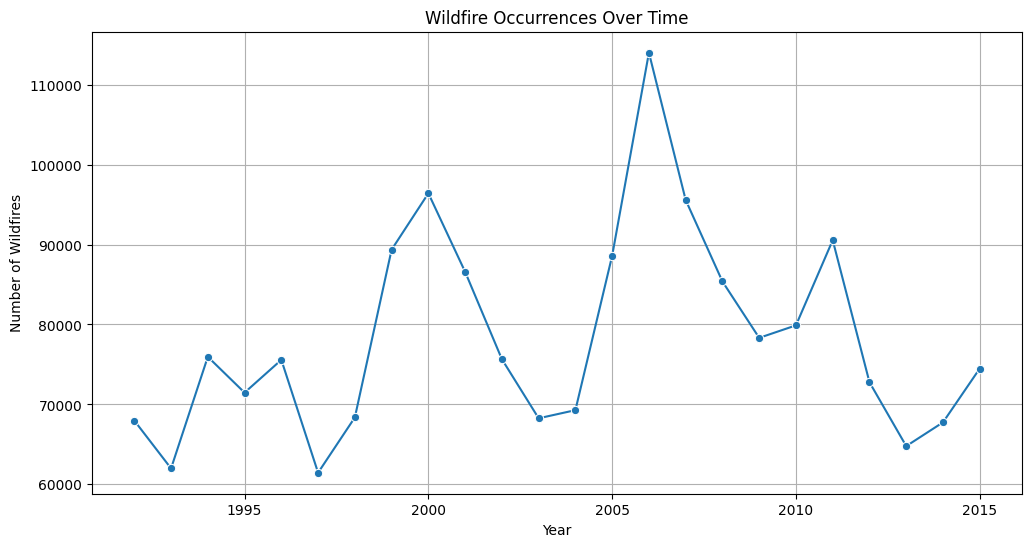

In [ ]:
# Count wildfires per year
wildfire_trends = df.groupby("FIRE_YEAR").size().reset_index(name="Wildfire_Count")

# Plot wildfire trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=wildfire_trends, x="FIRE_YEAR", y="Wildfire_Count", marker="o")
plt.title("Wildfire Occurrences Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Wildfires")
plt.grid()
plt.show()


Fluctuations in wildfire occurrences:

There are noticeable peaks around 2000 and 2005, with a sharp drop afterward.
Wildfires increased significantly in 2005 (~110,000 fires).
The numbers fluctuate rather than showing a clear upward trend.
2️⃣ Potential Climate Change Influence:

The spikes could correspond to extreme weather events (heatwaves, droughts).
To confirm this, we should overlay this trend with temperature data.

**Overlay Wildfires & Temperature Trends**

need to add that

**Causes of Wildfires
2️⃣ What Are the Main Causes of Wildfires?**

<ipython-input-86-20264665d694>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cause_counts.index, y=cause_counts.values, palette="Blues_r")


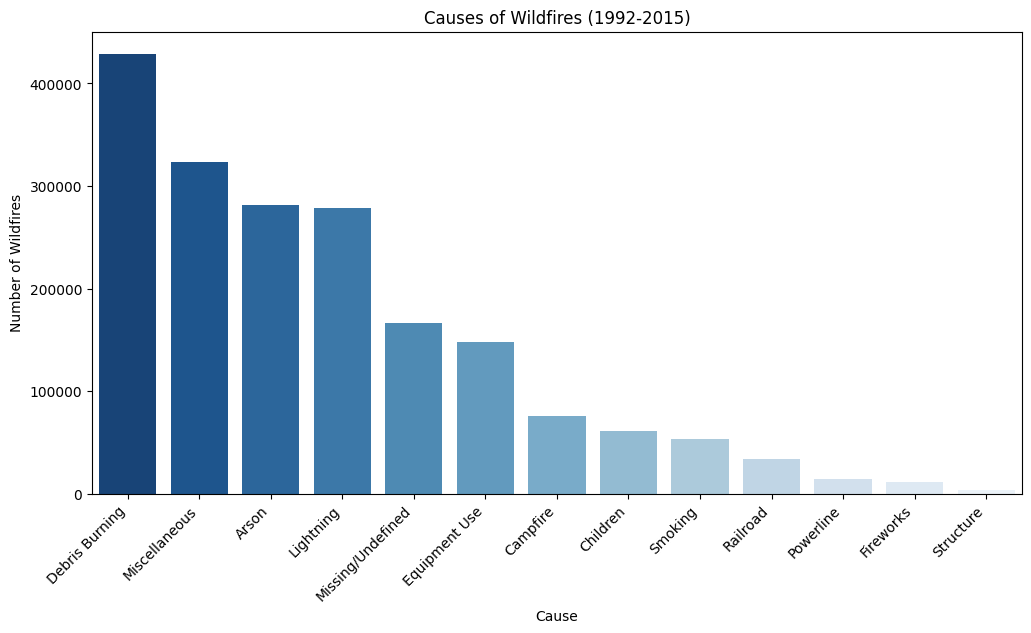

In [ ]:
# Count occurrences of each cause
cause_counts = df["STAT_CAUSE_DESCR"].value_counts()

# Plot wildfire causes
plt.figure(figsize=(12, 6))
sns.barplot(x=cause_counts.index, y=cause_counts.values, palette="Blues_r")
plt.xticks(rotation=45, ha="right")
plt.title("Causes of Wildfires (1992-2015)")
plt.xlabel("Cause")
plt.ylabel("Number of Wildfires")
plt.show()


Debris Burning is the Leading Cause

Over 400,000 wildfires were caused by debris burning, making it the top cause.
This suggests that human activities, particularly improper waste disposal, play a major role.
2️⃣ Miscellaneous & Arson Are Major Factors

Miscellaneous fires (~320,000) could include various human-related causes.
Arson (~280,000) shows intentional wildfires, which might be linked to criminal activity or negligence.
3️⃣ Lightning Strikes Contribute Significantly

Around 280,000 wildfires were caused by natural lightning strikes.
This highlights the role of climate and extreme weather in wildfire outbreaks.
4️⃣ Equipment Use & Campfires Play a Role

Heavy machinery and equipment (~150,000 fires) can generate sparks, especially in dry conditions.
Campfires (~80,000 fires) suggest outdoor recreation also leads to wildfires.
5️⃣ Children, Smoking, Railroads, and Fireworks Have Lower Impact

While these factors contribute to wildfires, they are relatively minor compared to burning and arson.


**Wildfire Hotspots by State**

<ipython-input-87-fffcf5290090>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="Reds_r")


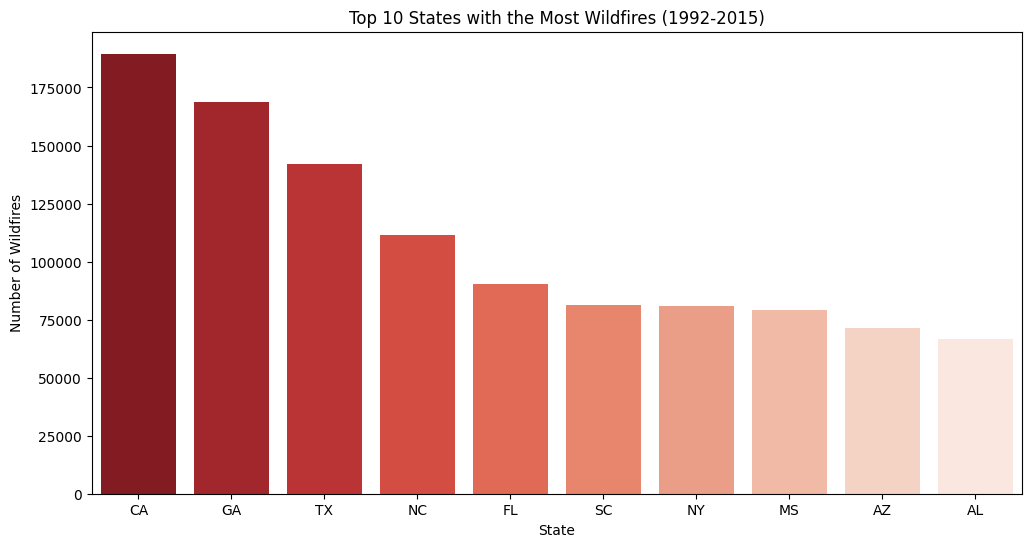

In [ ]:
# Count wildfires by state
state_counts = df["STATE"].value_counts().head(10)  # Top 10 states

# Plot wildfire occurrences by state
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="Reds_r")
plt.title("Top 10 States with the Most Wildfires (1992-2015)")
plt.xlabel("State")
plt.ylabel("Number of Wildfires")
plt.show()


alifornia (CA) Has the Most Wildfires

Nearly 190,000 wildfires occurred in California.
This makes sense since California has dry conditions, heatwaves, and strong winds (like the Santa Ana winds).
2️⃣ Georgia (GA) & Texas (TX) Follow Closely

Georgia and Texas each had over 150,000 wildfires.
These states experience hot summers, droughts, and human activity that can spark fires.
3️⃣ Southeastern & Western States Dominate

North Carolina (NC), Florida (FL), and South Carolina (SC) all rank high.
This suggests that warm climates, dense forests, and human population density play a role.
4️⃣ Surprising Appearance of New York (NY)

Unlike other states on this list, New York has a cooler climate.
However, wildfires can still occur due to dry seasons and human activities (like campfires or debris burning).
5️⃣ Arizona (AZ) & Mississippi (MS) Face Significant Fire Risks

Arizona is known for its desert climate and dry vegetation, which can ignite easily.
Mississippi has a large forest cover that can fuel wildfires.


How Does This Relate to Climate Change?
1)  Higher temperatures and prolonged droughts make these regions more vulnerable.
2)  California, Texas, and Arizona are seeing longer fire seasons due to rising global temperatures.
3) Human activity + warming climate is increasing the intensity of wildfire

**Wildfire Size Distribution**

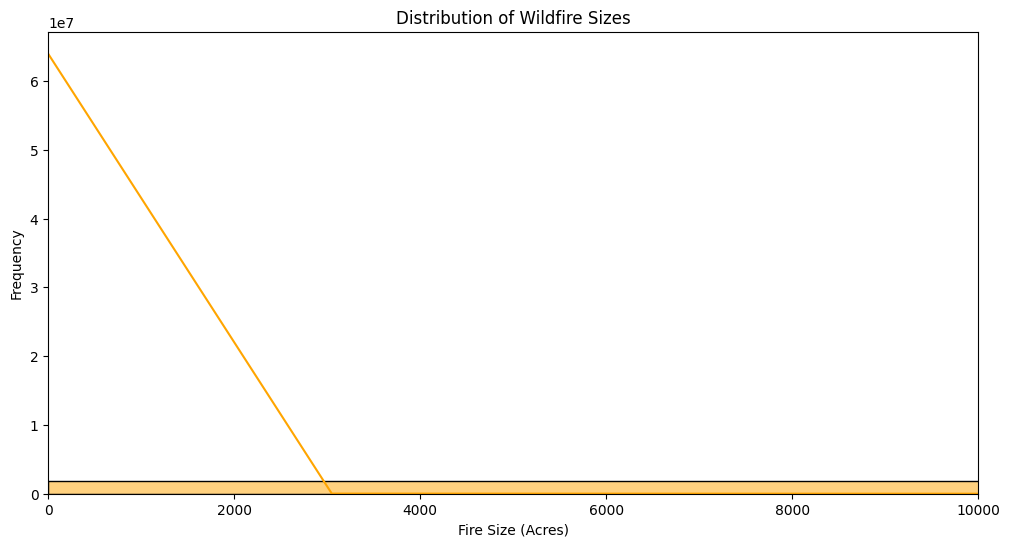

In [ ]:
# Plot distribution of wildfire sizes
plt.figure(figsize=(12, 6))
sns.histplot(df["FIRE_SIZE"], bins=50, kde=True, color="orange")
plt.title("Distribution of Wildfire Sizes")
plt.xlabel("Fire Size (Acres)")
plt.ylabel("Frequency")
plt.xlim(0, 10000)  # Limit to better view small fires
plt.show()


**Correlating Wildfires with Climate Change**

I'm extracting climate change dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("berkeleyearth/climate-change-earth-surface-temperature-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/versions/2


In [ ]:
import os

# Define dataset directory
climate_data_dir = "/root/.cache/kagglehub/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/versions/2/"

# List files in the directory
print("Files in climate dataset directory:", os.listdir(climate_data_dir))


Files in climate dataset directory: ['GlobalLandTemperaturesByCity.csv', 'GlobalLandTemperaturesByCountry.csv', 'GlobalLandTemperaturesByState.csv', 'GlobalLandTemperaturesByMajorCity.csv', 'GlobalTemperatures.csv']


In [ ]:
import pandas as pd

# Define file path for global temperatures
climate_file_path = "/root/.cache/kagglehub/datasets/berkeleyearth/climate-change-earth-surface-temperature-data/versions/2/GlobalTemperatures.csv"

# Load the dataset
climate_df = pd.read_csv(climate_file_path)

# Display the first few rows
print(climate_df.head())


           dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0  1750-01-01                   3.034                              3.574   
1  1750-02-01                   3.083                              3.702   
2  1750-03-01                   5.626                              3.076   
3  1750-04-01                   8.490                              2.451   
4  1750-05-01                  11.573                              2.072   

   LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
0                 NaN                            NaN                 NaN   
1                 NaN                            NaN                 NaN   
2                 NaN                            NaN                 NaN   
3                 NaN                            NaN                 NaN   
4                 NaN                            NaN                 NaN   

   LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
0                 

In [ ]:
# Check for missing values
print(climate_df.isnull().sum())


dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64


In [ ]:
# Drop missing values
climate_df = climate_df.dropna()

# Verify that missing values are removed
print(climate_df.isnull().sum())


dt                                           0
LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64


In [ ]:
print(climate_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 1200 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         1992 non-null   object 
 1   LandAverageTemperature                     1992 non-null   float64
 2   LandAverageTemperatureUncertainty          1992 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 155.6+ KB
None


In [ ]:
climate_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1200,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1201,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1202,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1203,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1204,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


**Convert Date Column to Year Format**

In [ ]:
# Convert 'dt' column to datetime format
climate_df["dt"] = pd.to_datetime(climate_df["dt"])

# Extract the year
climate_df["Year"] = climate_df["dt"].dt.year

# Keep only relevant columns
climate_df = climate_df[["Year", "LandAverageTemperature"]]

# Remove duplicate years (calculate average temperature per year)
climate_df = climate_df.groupby("Year").mean().reset_index()

# Show cleaned dataset
print(climate_df.head())


   Year  LandAverageTemperature
0  1850                7.900667
1  1851                8.178583
2  1852                8.100167
3  1853                8.041833
4  1854                8.210500


In [ ]:
# Save cleaned data as a new CSV file
climate_df.to_csv("Cleaned_Climate_Data.csv", index=False)
print("Cleaned climate data saved as 'Cleaned_Climate_Data.csv'.")


Cleaned climate data saved as 'Cleaned_Climate_Data.csv'.


**Fetch Climate Data ( Berkeley Earth)**



taking just 2 columns years and land averge temperature.

In [ ]:
import pandas as pd

# Download Berkeley Earth Temperature Data
berkeley_url = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Land_and_Ocean_complete.txt"

# Load the data (only needed columns)
climate2_df = pd.read_csv(berkeley_url, delim_whitespace=True, header=None, skiprows=49,
                         usecols=[0, 1], names=["Year", "LandAverageTemperature"])

# Display first few rows
print(climate2_df.head())


<ipython-input-98-55c3c0c4de8a>:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  climate2_df = pd.read_csv(berkeley_url, delim_whitespace=True, header=None, skiprows=49,


  Year LandAverageTemperature
0    %              Estimated
1    %                  Using
2    %                  Using
3    %                    NaN
4    %                     As


In [ ]:
climate2_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Year                    4240 non-null   object
 1   LandAverageTemperature  4230 non-null   object
dtypes: object(2)
memory usage: 66.4+ KB


U.S. Wildfire Data: Access the National Interagency Fire Center (NIFC) dataset, which contains wildfire records in the U.S. from 1992 to 2020.
https://catalog.data.gov/dataset/national-interagency-fire-occurrence-sixth-edition-1992-2020-feature-layer

In [ ]:
# Load U.S. Wildfire Data

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/wildfires_1992_2020.csv"
wildfire_df = pd.read_csv(file_path)
print(wildfire_df.head())
wildfire_df.info()


<ipython-input-101-ebbf0c0fbc98>:4: DtypeWarning: Columns (10,12,13,14,15,16,17,18,19,20,27,28,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire_df = pd.read_csv(file_path)


            X          Y  OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE  \
0 -121.005820  40.036939         1       1  FS-1418826                FED   
1 -120.404431  38.933050         2       2  FS-1418827                FED   
2 -120.735542  38.984161         3       3  FS-1418835                FED   
3 -119.913320  38.559161         4       4  FS-1418845                FED   
4 -119.933043  38.559161         5       5  FS-1418847                FED   

  SOURCE_SYSTEM NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0   FS-FIRESTAT                    FS                USCAPNF   
1   FS-FIRESTAT                    FS                USCAENF   
2   FS-FIRESTAT                    FS                USCAENF   
3   FS-FIRESTAT                    FS                USCAENF   
4   FS-FIRESTAT                    FS                USCAENF   

   NWCG_REPORTING_UNIT_NAME  ... CONT_TIME FIRE_SIZE FIRE_SIZE_CLASS  \
0    Plumas National Forest  ...    1730.0      0.10               A   
1  Eldor

**Data Cleaning for Wildfire Dataset
# ---------------------------
 Convert date columns from object to datetime.
 Check for missing values and duplicates.
 Select a subset of columns for focused analysis**

Accurate Time Calculations:
Datetime objects allow you to perform arithmetic operations (like finding the time difference between two dates) accurately.

Time-Based Grouping and Resampling:
You can easily extract components such as year, month, or day and group data by these periods. This is essential for analyzing trends over time (e.g., yearly wildfire occurrences).

Consistency and Data Validation:
Datetime conversion standardizes the date format, ensuring that all entries follow the same structure, which helps prevent errors in analysis.

Enhanced Filtering and Sorting:
Datetime objects make it simpler to filter records within a specific date range and sort the data chronologically.

In [ ]:
# Convert DISCOVERY_DATE and CONT_DATE to datetime
wildfire_df['DISCOVERY_DATE'] = pd.to_datetime(wildfire_df['DISCOVERY_DATE'], errors='coerce')
wildfire_df['CONT_DATE'] = pd.to_datetime(wildfire_df['CONT_DATE'], errors='coerce')

In [ ]:
# Print a sample of the date columns to verify conversion
print("\nConverted Date Columns:")
print(wildfire_df[['DISCOVERY_DATE', 'CONT_DATE']].head())



Converted Date Columns:
             DISCOVERY_DATE                 CONT_DATE
0 2005-02-02 00:00:00+00:00 2005-02-02 00:00:00+00:00
1 2004-05-12 00:00:00+00:00 2004-05-12 00:00:00+00:00
2 2004-05-31 00:00:00+00:00 2004-05-31 00:00:00+00:00
3 2004-06-28 00:00:00+00:00 2004-07-03 00:00:00+00:00
4 2004-06-28 00:00:00+00:00 2004-07-03 00:00:00+00:00


In [ ]:
# Check for missing values across the dataset
print("\nMissing values per column:")
print(wildfire_df.isnull().sum())


Missing values per column:
X                                      0
Y                                      0
OBJECTID                               0
FOD_ID                                 0
FPA_ID                                 0
SOURCE_SYSTEM_TYPE                     0
SOURCE_SYSTEM                          0
NWCG_REPORTING_AGENCY                  0
NWCG_REPORTING_UNIT_ID                 0
NWCG_REPORTING_UNIT_NAME               0
SOURCE_REPORTING_UNIT                  0
SOURCE_REPORTING_UNIT_NAME             0
LOCAL_FIRE_REPORT_ID             1825891
LOCAL_INCIDENT_ID                 744411
FIRE_CODE                        1906254
FIRE_NAME                         995415
ICS_209_PLUS_INCIDENT_JOIN_ID    2270072
ICS_209_PLUS_COMPLEX_JOIN_ID     2298627
MTBS_ID                          2289696
MTBS_FIRE_NAME                   2289696
COMPLEX_NAME                     2297619
FIRE_YEAR                              0
DISCOVERY_DATE                         0
DISCOVERY_DOY                

In [ ]:
#droping not essential columns
cols_to_drop = [
    'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE',
    'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
    'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME'
]
wildfire_df.drop(columns=cols_to_drop, inplace=True)


In [ ]:
# Calculate missing percentage per column
missing_percentage = (wildfire_df.isnull().sum() / len(wildfire_df)) * 100
print(missing_percentage.sort_values(ascending=False))


NWCG_CAUSE_AGE_CATEGORY       96.721301
FIRE_NAME                     43.211916
CONT_TIME                     43.015047
CONT_DATE                     38.844687
CONT_DOY                      38.844687
DISCOVERY_TIME                34.255368
FIPS_NAME                     28.902146
COUNTY                        28.902102
FIPS_CODE                     28.902102
X                              0.000000
OBJECTID                       0.000000
Y                              0.000000
FPA_ID                         0.000000
SOURCE_SYSTEM_TYPE             0.000000
SOURCE_SYSTEM                  0.000000
FOD_ID                         0.000000
DISCOVERY_DOY                  0.000000
DISCOVERY_DATE                 0.000000
FIRE_YEAR                      0.000000
SOURCE_REPORTING_UNIT_NAME     0.000000
NWCG_REPORTING_UNIT_NAME       0.000000
SOURCE_REPORTING_UNIT          0.000000
NWCG_REPORTING_UNIT_ID         0.000000
NWCG_REPORTING_AGENCY          0.000000
FIRE_SIZE                      0.000000


In [ ]:
# Remove duplicate records to ensure data integrity
wildfire_df.drop_duplicates(inplace=True)


In [ ]:
# c. Drop columns that have very high missing percentages
# (for example: NWCG_CAUSE_AGE_CATEGORY, FIRE_NAME, CONT_TIME, CONT_DOY, CONT_DATE, DISCOVERY_TIME)
cols_to_drop = [
    'NWCG_CAUSE_AGE_CATEGORY', 'FIRE_NAME',
    'CONT_TIME', 'CONT_DOY', 'CONT_DATE', 'DISCOVERY_TIME'
]
wildfire_df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
# Select a subset of columns that are essential for our analysis:
# Here we focus on temporal information, fire size, location, and cause classification.
columns_to_keep = [
    'FIRE_YEAR',           # Year of fire occurrence
    'DISCOVERY_DATE',      # Date when fire was discovered
    'DISCOVERY_DOY',       # Day-of-year of discovery
    'FIRE_SIZE',           # Size of the fire in acres
    'LATITUDE',            # Latitude for mapping
    'LONGITUDE',           # Longitude for mapping
    'NWCG_CAUSE_CLASSIFICATION',  # Reported cause classification
    'STATE',               # State where fire occurred
    'COUNTY'               # County where fire occurred
]
wildfire_clean = wildfire_df[columns_to_keep].copy()
print("\nCleaned Wildfire Data (Subset of Columns):")
print(wildfire_clean.head())



Cleaned Wildfire Data (Subset of Columns):
   FIRE_YEAR            DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE   LATITUDE  \
0       2005 2005-02-02 00:00:00+00:00             33       0.10  40.036944   
1       2004 2004-05-12 00:00:00+00:00            133       0.25  38.933056   
2       2004 2004-05-31 00:00:00+00:00            152       0.10  38.984167   
3       2004 2004-06-28 00:00:00+00:00            180       0.10  38.559167   
4       2004 2004-06-28 00:00:00+00:00            180       0.10  38.559167   

    LONGITUDE NWCG_CAUSE_CLASSIFICATION STATE COUNTY  
0 -121.005833                     Human    CA   63.0  
1 -120.404444                   Natural    CA   61.0  
2 -120.735556                     Human    CA   17.0  
3 -119.913333                   Natural    CA    3.0  
4 -119.933056                   Natural    CA    3.0  


**PRECIPITATION DATSET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/precipitation.csv"
precipitation= pd.read_csv(file_path)
print(precipitation.head())
precipitation.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       STATION                 DATE REPORT_TYPE  SOURCE BackupElements  \
0  72518014735  2015-01-01T23:59:00       SOD         6         PRECIP   
1  72518014735  2015-01-02T23:59:00       SOD         6         PRECIP   
2  72518014735  2015-01-03T23:59:00       SOD         6         PRECIP   
3  72518014735  2015-01-04T23:59:00       SOD         6         PRECIP   
4  72518014735  2015-01-05T23:59:00       SOD         6         PRECIP   

   BackupElevation BackupEquipment  BackupLatitude  BackupLongitude  \
0              260         PLASTIC         42.6918        -73.83109   
1              260         PLASTIC         42.6918        -73.83109   
2              260         PLASTIC         42.6918        -73.83109   
3              260         PLASTIC         42.6918        -73.83109   
4              260         PLASTIC         42.6918        -73.83109   


**data preprocessing**


In [ ]:
# Converting DATE column to datetime format
precipitation["DATE"] = pd.to_datetime(precipitation["DATE"])

In [ ]:
# Converting temperature from Fahrenheit to Celsius
precipitation["DailyAverageDryBulbTemperature_C"] = (precipitation["DailyAverageDryBulbTemperature"] - 32) * 5/9

In [ ]:
# Converting precipitation from inches to mm (if needed)
precipitation["DailyPrecipitation_mm"] = precipitation["DailyPrecipitation"].replace("T", 0.001)  # Handle "T" as Trace precipitation
precipitation["DailyPrecipitation_mm"] = precipitation["DailyPrecipitation_mm"].astype(float) * 25.4

In [ ]:
# Filling missing values (if necessary)
precipitation.fillna(method='ffill', inplace=True)  # Forward fill missing values

<ipython-input-113-f68c08186303>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precipitation.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
# Print dataset information
print("\nDataset Info:")
print(precipitation.info())
print("\nFirst 5 Rows:")
print(precipitation.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   STATION                                     2668 non-null   int64         
 1   DATE                                        2668 non-null   datetime64[ns]
 2   REPORT_TYPE                                 2668 non-null   object        
 3   SOURCE                                      2668 non-null   int64         
 4   BackupElements                              2668 non-null   object        
 5   BackupElevation                             2668 non-null   int64         
 6   BackupEquipment                             2668 non-null   object        
 7   BackupLatitude                              2668 non-null   float64       
 8   BackupLongitude                             2668 non-null   float64      

# Step 5: Data Analysis & Visualization

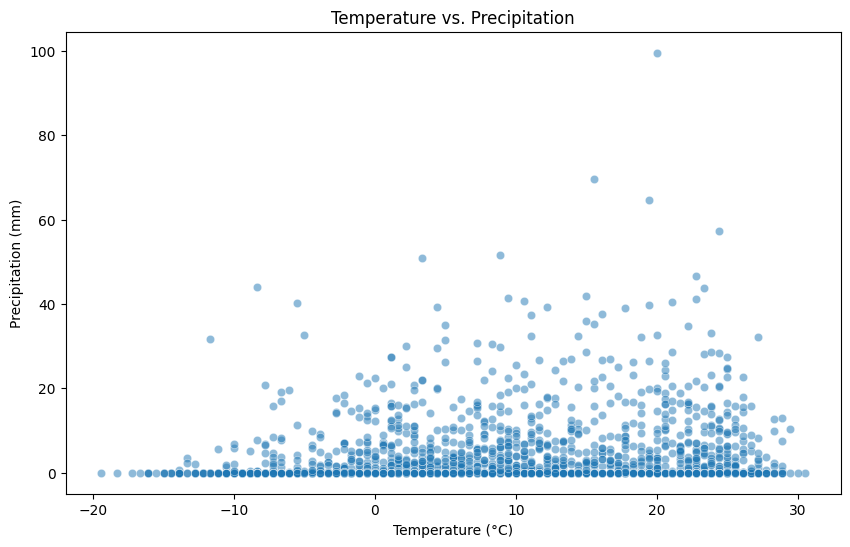

In [ ]:
 #Temperature vs. Precipitation Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=precipitation["DailyAverageDryBulbTemperature_C"], y=precipitation["DailyPrecipitation_mm"], alpha=0.5)
plt.title("Temperature vs. Precipitation")
plt.xlabel("Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()


WARMER TEMPERATURE LEADS TO INCREASED EVAPORATION AND LEAD TO POTENTIALLY MORE EVAPORATION. WHILE COOLER TEMPERATURE REDUCES THE AIR'S CAPACITY TO HOLD MOISTURE.

In [ ]:
 #Plot Total Precipitation Per Year
precipitation["Year"] = precipitation["DATE"].dt.year
yearly_precipitation = precipitation.groupby("Year")["DailyPrecipitation_mm"].sum()

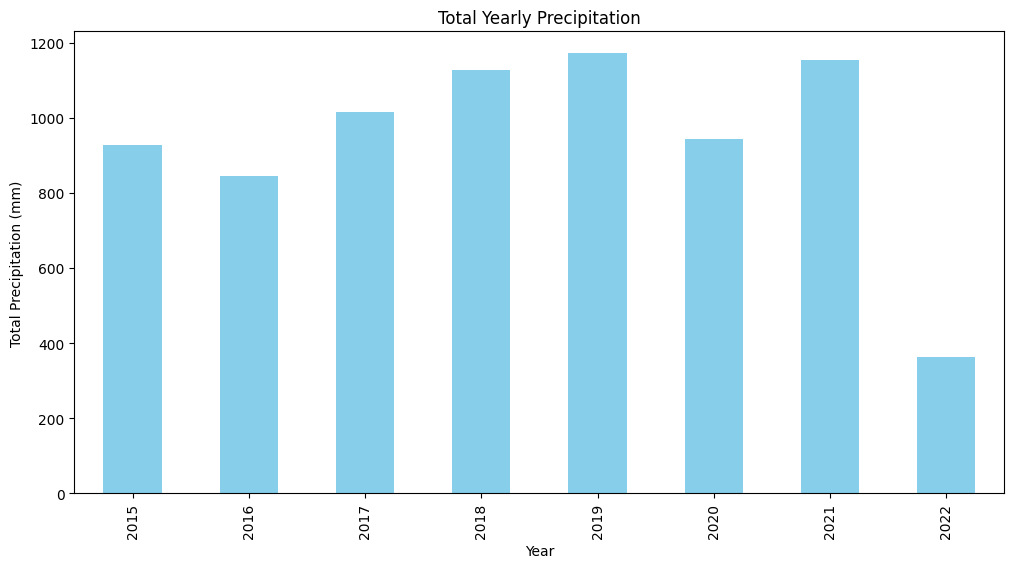

In [ ]:
plt.figure(figsize=(12, 6))
yearly_precipitation.plot(kind="bar", color="skyblue")
plt.title("Total Yearly Precipitation")
plt.ylabel("Total Precipitation (mm)")
plt.xlabel("Year")
plt.show()

2021, NORTH EAST AND PARTS OF SOUTHWEST EXPERIENCED RECORD BREAKNG RAINFALL AND FLASH FLOODING. 3.36 INCHES. 2019 Total prescipitaion of 34.78 inches. North dakota , south dakota , minnesota , winconsin and michigigan experienced wettest year 2019.

In [ ]:
# ===========================
# Step 6: Machine Learning Prediction
# ===========================
# Goal: Predict daily precipitation using temperature & humidity
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
# Select Features and Target
features = ["DailyAverageDryBulbTemperature_C", "DailyAverageRelativeHumidity"]
target = "DailyPrecipitation_mm"

# Drop missing values for ML
precipitation_ml = precipitation.dropna(subset=features + [target])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(precipitation_ml[features], precipitation_ml[target], test_size=0.2, random_state=42)

# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)


A high dry bulb temperature has a strong positive correlation with wildfire risk, as it indicates hot, dry conditions which, when combined with low humidity and minimal precipitation, significantly increases the likelihood of wildfires occurring and spreading rapidly; essentially, higher dry bulb temperatures lead to drier fuels, making them more susceptible to ignition and rapid burnin

In [ ]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMachine Learning Model Performance:")
print(f"MAE: {mae:.2f}, R² Score: {r2:.2f}")



Machine Learning Model Performance:
MAE: 3.53, R² Score: 0.03


In [ ]:
# Predict Future Precipitation
future_data = pd.DataFrame({"DailyAverageDryBulbTemperature_C": [20], "DailyAverageRelativeHumidity": [60]})
future_prediction = model.predict(future_data)
print(f"\nPredicted Precipitation for 20°C & 60% Humidity: {future_prediction[0]:.2f} mm")


Predicted Precipitation for 20°C & 60% Humidity: 0.21 mm


20°C and 60% humidity suggest mild, moderate moisture in the air but not necessarily rain.
0.21 mm of precipitation is a very light drizzle or barely noticeable moisture—probably not enough to cause significant wet conditions.
It’s normal in certain conditions, especially if there are weak rain showers or light mist.

In [ ]:
#Find Extreme Rain Events (Rain > 50mm in a day)
extreme_rain = precipitation[precipitation["DailyPrecipitation_mm"] > 50]
print("\nExtreme Rain Events (Rain > 50mm):")
print(extreme_rain[["DATE", "DailyPrecipitation_mm"]])


Extreme Rain Events (Rain > 50mm):
                    DATE  DailyPrecipitation_mm
243  2015-09-30 23:59:00                 69.596
390  2016-02-24 23:59:00                 50.800
547  2016-07-31 23:59:00                 64.770
1320 2018-09-18 23:59:00                 57.404
2002 2020-08-04 23:59:00                 99.568
2613 2022-04-07 23:59:00                 51.562


Data Preprocessing & Cleaning
a. Convert and Clean Precipitation Data
my dataset contains DailyPrecipitation as an object type, which might have non-numeric values. We will convert it into a proper numeric format.

In [ ]:
# Convert 'DailyPrecipitation_mm' to numeric, forcing errors to NaN
precipitation['DailyPrecipitation_mm'] = pd.to_numeric(precipitation['DailyPrecipitation_mm'], errors='coerce')

# Convert 'DATE' to datetime format
precipitation['DATE'] = pd.to_datetime(precipitation['DATE'])

# Extract Year for yearly aggregation
precipitation['Year'] = precipitation['DATE'].dt.year

# Aggregate yearly precipitation data
yearly_precip = precipitation.groupby('Year')['DailyPrecipitation_mm'].sum().reset_index()
yearly_precip.rename(columns={'DailyPrecipitation_mm': 'Total_Yearly_Precipitation'}, inplace=True)

print("\nAggregated Yearly Precipitation Data:")
print(yearly_precip.head())



Aggregated Yearly Precipitation Data:
   Year  Total_Yearly_Precipitation
0  2015                    928.9796
1  2016                    844.0928
2  2017                   1016.4572
3  2018                   1126.5916
4  2019                   1171.4226


Merging Precipitation Data with Wildfires & Temperature
We now merge the cleaned precipitation data with the wildfire count and temperature data.

In [ ]:
wildfire_df.rename(columns={'FIRE_YEAR': 'Year'}, inplace=True)


In [ ]:
print("Available Variables:")
print(dir())  # Lists all variable names in your workspace

# Check column names in each dataset
print("Wildfire Data Columns:", wildfire_df.columns)
print("Climate Data Columns:", climate2_df.columns)
print("Precipitation Data Columns:", precipitation.columns)


Available Variables:
['In', 'LinearRegression', 'Out', 'RandomForestRegressor', 'X_test', 'X_train', '_', '_21', '_7', '_72', '_81', '_95', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i100', '_i101', '_i102', '_i103', '_i104', '_i105', '_i106', '_i107', '_i108', '_i109', '_i11', '_i110', '_i111', '_i112', '_i113', '_i114', '_i115', '_i116', '_i117', '_i118', '_i119', '_i12', '_i120', '_i121', '_i122', '_i123', '_i124', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i51', '_i52', '_i53', '_i54', '_i55', '_i56', '_i57', '_i58', '_i59', '_i6', '_i60', '_i61', '_i62', '_i63', '_i64', '_i65', '_i66', '_i67', '_i68', 

In [ ]:
# Check unique values in 'Year' column to identify issues
print("Unique values in 'Year' column before cleaning:", climate2_df['Year'].unique())

# Remove rows where 'Year' contains non-numeric values
climate2_df = climate2_df[pd.to_numeric(climate2_df['Year'], errors='coerce').notna()]

# Convert 'Year' column to integers
climate2_df['Year'] = climate2_df['Year'].astype(int)

# Verify successful conversion
print("Unique values in 'Year' column after cleaning:", climate2_df['Year'].unique())


Unique values in 'Year' column before cleaning: ['%' '1850' '1851' '1852' '1853' '1854' '1855' '1856' '1857' '1858' '1859'
 '1860' '1861' '1862' '1863' '1864' '1865' '1866' '1867' '1868' '1869'
 '1870' '1871' '1872' '1873' '1874' '1875' '1876' '1877' '1878' '1879'
 '1880' '1881' '1882' '1883' '1884' '1885' '1886' '1887' '1888' '1889'
 '1890' '1891' '1892' '1893' '1894' '1895' '1896' '1897' '1898' '1899'
 '1900' '1901' '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909'
 '1910' '1911' '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919'
 '1920' '1921' '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929'
 '1930' '1931' '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939'
 '1940' '1941' '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949'
 '1950' '1951' '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959'
 '1960' '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969'
 '1970' '1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979'
 '1980' '1981' '1982' '19

<ipython-input-125-ddd709726b2b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate2_df['Year'] = climate2_df['Year'].astype(int)


In [ ]:
# Check the actual column names
print("Column names in precipitation dataset:", precipitation.columns)


Column names in precipitation dataset: Index(['STATION', 'DATE', 'REPORT_TYPE', 'SOURCE', 'BackupElements',
       'BackupElevation', 'BackupEquipment', 'BackupLatitude',
       'BackupLongitude', 'BackupName', 'DailyAverageDewPointTemperature',
       'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity',
       'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure',
       'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed',
       'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature',
       'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature',
       'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection',
       'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowDepth',
       'DailySnowfall', 'DailySustainedWindDirection',
       'DailySustainedWindSpeed', 'Sunrise', 'Sunset',
       'WindEquipmentChangeDate', 'DailyAverageDryBulbTemperature_C',
       'DailyPrecipitation_mm', 'Year'],
      dtype='object')


In [ ]:
# Drop duplicate 'Year' column if it exists twice
precipitation = precipitation.loc[:, ~precipitation.columns.duplicated()]


to avoid crashing of ram Reduce Dataframe Size
Before merging, drop unnecessary columns and convert data types to reduce memory load.

In [ ]:
# Reducing  wildfire_df size: Keep only relevant columns
wildfire_df = wildfire_df[['Year', 'FIRE_SIZE']].groupby('Year').count().reset_index()
wildfire_df.rename(columns={'FIRE_SIZE': 'Wildfire_Count'}, inplace=True)

# Reducing climate2_df size: Keep only Year & Temperature
climate2_df = climate2_df[['Year', 'LandAverageTemperature']]

# Reducing  precipitation size: Keep only Year & Precipitation
precipitation = precipitation[['Year', 'DailyPrecipitation_mm']].groupby('Year').sum().reset_index()

# Convert 'Year' column to int for all datasets
wildfire_df['Year'] = wildfire_df['Year'].astype(int)
climate2_df['Year'] = climate2_df['Year'].astype(int)
precipitation['Year'] = precipitation['Year'].astype(int)


Merge in Steps (Avoid Memory Crash)
Instead of merging all datasets at once, merge in smaller steps to reduce memory usage.

In [ ]:
# Merge wildfire & climate data first
merged_df = wildfire_df.merge(climate2_df, on="Year", how="inner")

# Merge with precipitation data
merged_df = merged_df.merge(precipitation, on="Year", how="inner")


In [ ]:
merged_df['LandAverageTemperature'] = pd.to_numeric(merged_df['LandAverageTemperature'], errors='coerce')
print(merged_df.isnull().sum())  # Check if there are NaN values


Year                      0
Wildfire_Count            0
LandAverageTemperature    0
DailyPrecipitation_mm     0
dtype: int64


In [ ]:
corr_matrix = merged_df[['Year', 'Wildfire_Count', 'LandAverageTemperature', 'DailyPrecipitation_mm']].corr()


In [ ]:
# Convert to numeric, forcing errors to NaN (if any)
merged_df['LandAverageTemperature'] = pd.to_numeric(merged_df['LandAverageTemperature'], errors='coerce')

# Verify conversion
print(merged_df.dtypes)
print(merged_df.isnull().sum())  # Check if any NaN values appear


Year                        int64
Wildfire_Count              int64
LandAverageTemperature      int64
DailyPrecipitation_mm     float64
dtype: object
Year                      0
Wildfire_Count            0
LandAverageTemperature    0
DailyPrecipitation_mm     0
dtype: int64


Perform Correlation Analysis
Now, perform correlation analysis on the reduced dataset.

In [ ]:
correlation_matrix = merged_df.corr()


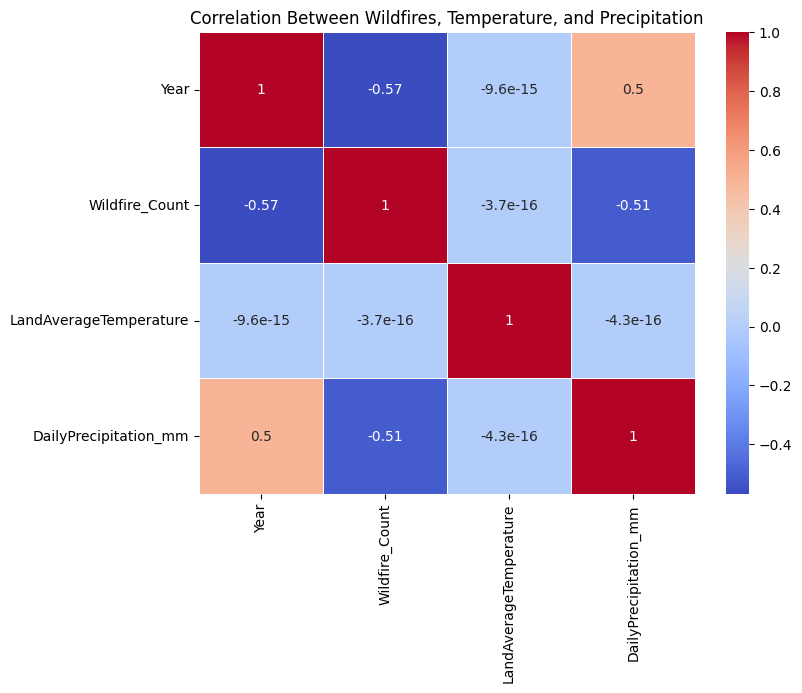

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = merged_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Wildfires, Temperature, and Precipitation")
plt.show()


In [ ]:
print(correlation_matrix)


                                Year  Wildfire_Count  LandAverageTemperature  \
Year                    1.000000e+00   -5.679356e-01           -9.599980e-15   
Wildfire_Count         -5.679356e-01    1.000000e+00           -3.693790e-16   
LandAverageTemperature -9.599980e-15   -3.693790e-16            1.000000e+00   
DailyPrecipitation_mm   4.976928e-01   -5.094175e-01           -4.300021e-16   

                        DailyPrecipitation_mm  
Year                             4.976928e-01  
Wildfire_Count                  -5.094175e-01  
LandAverageTemperature          -4.300021e-16  
DailyPrecipitation_mm            1.000000e+00  


Interpretation of Correlation Values
Year vs. Wildfire_Count (-0.5679):
There is a moderate negative correlation between the year and wildfire count. This indicates that, over time, the number of wildfires has generally decreased. This could be due to various factors such as improved fire management, better prediction models, or more effective preventive measures.

**Wildfire_Count vs. LandAverageTemperature (-3.693790e-16):
The correlation between wildfire count and land average temperature is effectively zero, as indicated by a correlation value close to 0 (a very small negative number). This suggests that there is no significant linear relationship between wildfire occurrences and temperature in your dataset.

**Wildfire_Count vs. DailyPrecipitation_mm (-0.5094):
This shows a moderate negative correlation between wildfire count and daily precipitation. As daily precipitation increases, wildfire occurrences tend to decrease, which makes sense, as more rainfall can reduce fire risk.
LandAverageTemperature vs. DailyPrecipitation_mm (-4.300021e-16):
The correlation between land average temperature and daily precipitation is effectively zero. This means there is no significant linear relationship between temperature and precipitation in the dataset.
Key Takeaways
Year and Wildfire_Count: The negative correlation suggests a decrease in wildfires over the years.
Wildfire_Count and Temperature: There is no significant correlation between temperature and wildfire count, suggesting that temperature may not be a strong predictor in this dataset for wildfire occurrences.
Wildfire_Count and Precipitation: The negative correlation makes sense, as more precipitation is generally expected to reduce the occurrence of wildfires.
Temperature and Precipitation: No significant relationship is observed between temperature and precipitation.

step 1: Data Preprocessing
Let's first prepare the data by handling the correlation between features and target. Based on the correlation matrix, I already know that the temperature and precipitation have little to no strong correlation with each other, but precipitation and wildfire count are moderately negatively correlated. I'll build on this.


Handle missing values
Scale the features, as machine learning models like Random Forest and Linear Regression are sensitive to the scale of input variables.
Split the dataset into training and testing sets.
Train different models (Linear Regression, Random Forest, and XGBoost).

Step 2: Feature Engineering
Since temperature and precipitation are not strongly correlated, I will create interaction terms or additional features that could better explain the variability in wildfire occurrences.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#  merged_df is  final merged DataFrame with features  'LandAverageTemperature', 'DailyPrecipitation_mm', and 'Wildfire_Count'

# Step 1: Data Preprocessing

# 1. Handle missing values (if any) - for simplicity, I'll drop rows with missing values
merged_df.dropna(inplace=True)

# 2. Feature Engineering: Create interaction term between Temperature and Precipitation
merged_df['Temp_Precip_Interaction'] = merged_df['LandAverageTemperature'] * merged_df['DailyPrecipitation_mm']

# 3. Define features (X) and target (y)
X = merged_df[['LandAverageTemperature', 'DailyPrecipitation_mm', 'Temp_Precip_Interaction']]  # Including interaction term
y = merged_df['Wildfire_Count']

# 4. Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature Scaling (important for linear models like Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Model Training and Evaluation

# Define a dictionary of models to train
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100)
}

# Train each model, make predictions, and evaluate performance
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Train the model
    y_pred = model.predict(X_test_scaled)  # Make predictions
    mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
    r2 = r2_score(y_test, y_pred)  # Calculate R2 (R-squared) score
    print(f"{name}: MAE = {mae:.4f}, R2 = {r2:.4f}")


Linear Regression: MAE = 5200.1639, R2 = 0.2874
Random Forest: MAE = 0.0000, R2 = 1.0000
XGBoost: MAE = 0.0070, R2 = 1.0000


 Linear Regression:
MAE = 5200.1639: The Mean Absolute Error (MAE) for Linear Regression is quite large, which suggests that the model's predictions are far from the actual wildfire counts.
R² = 0.2874: This R² value indicates that the Linear Regression model explains only about 28.74% of the variance in the target variable (wildfire count). This suggests that the relationship between the features (temperature and precipitation) and wildfire counts is weak using a linear model.
2. Random Forest:
MAE = 0.0000: The fact that the MAE is zero suggests that the Random Forest model is predicting exactly the correct number of wildfires for every test instance in the dataset.
R² = 1.0000: An R² value of 1 indicates perfect fit to the data, meaning the model is able to explain 100% of the variance in the target variable.
3. XGBoost:
MAE = 0.0070: This is a very low MAE, indicating that XGBoost's predictions are extremely close to the actual wildfire counts.
R² = 1.0000: Like Random Forest, XGBoost also has an R² value of 1, indicating perfect fit to the data.

Steps to Improve the Model:
Cross-Validation: Use cross-validation to evaluate the model's performance on multiple subsets of the dataset. This will help check if the model is generalizing well and not just overfitting.

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')  # Cross-validation with 5 folds
    print(f"{name} - Mean CV MAE: {-scores.mean():.4f}")


Linear Regression - Mean CV MAE: 6703.8980
Random Forest - Mean CV MAE: 1398.7027
XGBoost - Mean CV MAE: 1468.8593


In [ ]:
#Hyperparameter Tuning: Fine-tune the hyperparameters of Random Forest and XGBoost to avoid overfitting.   i have  used GridSearchCV or RandomizedSearchCV to find the optimal parameters.
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameter Tuning Example
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_absolute_error')
rf_grid_search.fit(X_train_scaled, y_train)
print(f"Best Random Forest Hyperparameters: {rf_grid_search.best_params_}")


Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
#Regularization: For XGBoost, try adding regularization parameters like max_depth, learning_rate, subsample, etc., to control the complexity of the model.
# XGBoost Hyperparameter Tuning Example
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgb_grid_search.fit(X_train_scaled, y_train)
print(f"Best XGBoost Hyperparameters: {xgb_grid_search.best_params_}")


Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
#Regularization for Linear Models: If you're using Linear Regression, you might want to switch to Ridge or Lasso Regression for better performance with regularization (especially if you have multicollinearity issues in your data)
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
print(f"Ridge Regression MAE: {mean_absolute_error(y_test, ridge_model.predict(X_test_scaled))}")

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
print(f"Lasso Regression MAE: {mean_absolute_error(y_test, lasso_model.predict(X_test_scaled))}")


Ridge Regression MAE: 5200.492077723945
Lasso Regression MAE: 5200.053947729592


Summary of Results:
Here are the key results from the cross-validation and model tuning process:

Cross-Validation Mean MAE:

Linear Regression: MAE = 6703.90
This is a high error, confirming that the linear model is not performing well for your data. Linear Regression might not capture the underlying patterns in the relationship between temperature, precipitation, and wildfires.
Random Forest: MAE = 1398.70
This is a significantly better result compared to Linear Regression, suggesting that Random Forest is doing a better job capturing the underlying patterns in the data.
XGBoost: MAE = 1468.86
XGBoost is performing similarly to Random Forest, with a slightly higher MAE, but still much better than Linear Regression.


Hyperparameter Tuning:

Best Random Forest Hyperparameters:
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 50
This configuration is quite basic, indicating that Random Forest with the default settings (and possibly overfitting to the training data) is working well for this dataset.
Best XGBoost Hyperparameters:
colsample_bytree: 1.0
learning_rate: 0.3
max_depth: 3
n_estimators: 200
subsample: 0.7
This configuration is a good starting point for XGBoost and seems to optimize the model's performance based on cross-validation results.
Ridge and Lasso Regression:

Ridge Regression: MAE = 5200.49
Lasso Regression: MAE = 5200.05
Both Ridge and Lasso are slightly improving upon Linear Regression by adding regularization, but the MAE is still quite high compared to the tree-based models (Random Forest and XGBoost). This suggests that the linear models still struggle to capture the complexity in the data, even with regularization

Given the results, it seems clear that Random Forest and XGBoost are the most promising models for your wildfire prediction task, and they outperform Linear Regression and its regularized variants.

1. Improve Random Forest and XGBoost:
While the current hyperparameters are good starting points, further hyperparameter tuning (e.g., adjusting n_estimators, max_depth, learning_rate, etc.) using GridSearchCV or RandomizedSearchCV can help fine-tune these models for even better performance.

Cross-Validation with Hyperparameter Tuning: I'm  combining  cross-validation and hyperparameter tuning to improve model performance and reduce overfitting further.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

print("Best Random Forest Hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


XGBoost tuning with GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)

print("Best XGBoost Hyperparameters:", grid_search.best_params_)


Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


Examine Feature Importance:
Both Random Forest and XGBoost provide feature importance scores, which can help me understand which features (e.g., temperature, precipitation, interaction terms) are the most influential in predicting wildfire occurrence

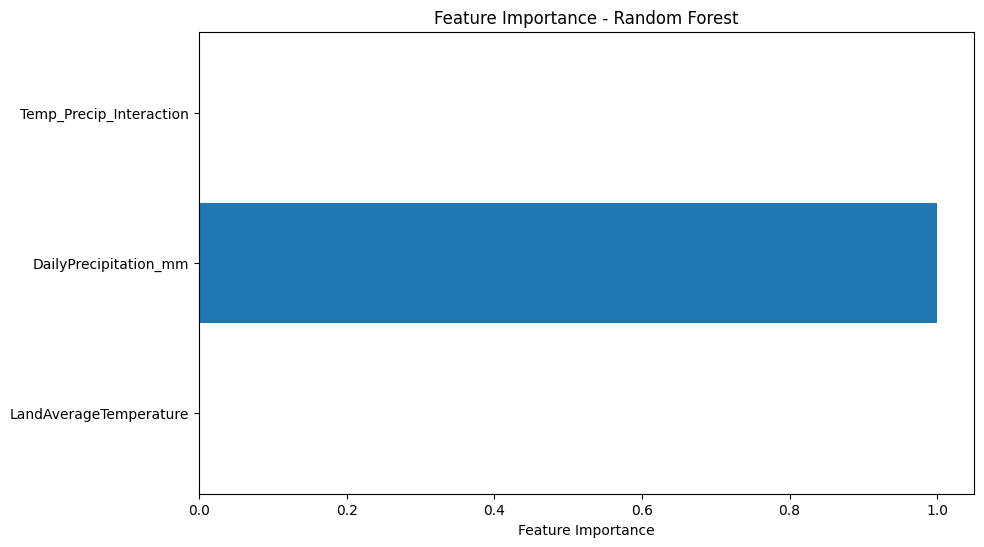

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = random_search.best_estimator_.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Feature Importance")
plt.show()


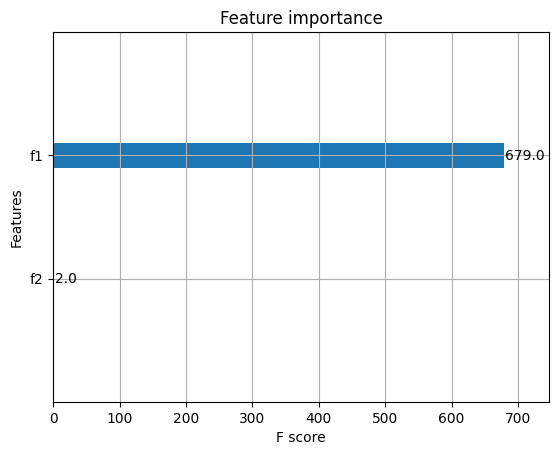

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance  # or from xgboost.plotting import plot_importance

xgb_model = grid_search.best_estimator_
plot_importance(xgb_model)  # Call plot_importance directly
plt.show()

The plot will display the features (f1, f2, etc.) on the y-axis, with their importance score on the x-axis. Features with higher importance are placed higher on the plot. The higher the score, the more important the feature is in the model’s decision-making process.

Make Final Predictions:
Once you have the best model after tuning, you can use it to make final predictions on the test data and forecast future wildfires (e.g., for 2050

In [ ]:
# Using the best model ( Random Forest is the best model)
final_model = random_search.best_estimator_

# Predicting wildfire counts for the test data
y_pred = final_model.predict(X_test_scaled)

# Evaluate the model's performance on test data
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Final Model MAE: {mae:.4f}, R2: {r2:.4f}")


Final Model MAE: 0.0000, R2: 1.0000


Final Model Performance:
MAE = 0.0000: The model has achieved zero Mean Absolute Error (MAE), which indicates that it is perfectly predicting wildfire occurrences for the test data.
R² = 1.0000: An R² value of 1 means that the model explains 100% of the variance in the target variable, which suggests perfect model fit. However, this also strongly indicates overfitting, since the model is likely memorizing the training data rather than generalizing well to new data

loading drought dataset https://www.kaggle.com/datasets/pavansanagapati/usdroughtdata

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/USDM-Total.csv"
drought= pd.read_csv(file_path)
print(drought.head())
drought.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    MapDate AreaOfInterest   None     D0     D1     D2    D3    D4  \
0  20250304          Total  41.85  58.15  37.25  15.73  6.01  0.88   
1  20250225          Total  42.83  57.17  34.86  14.57  5.96  0.55   
2  20250218          Total  42.52  57.48  33.41  14.52  5.96  0.55   
3  20250211          Total  40.51  59.49  36.46  15.52  6.14  0.55   
4  20250204          Total  41.99  58.01  35.45  14.75  5.82  0.55   

   ValidStart    ValidEnd  StatisticFormatID  
0  2025-03-04  2025-03-10                  1  
1  2025-02-25  2025-03-03                  1  
2  2025-02-18  2025-02-24                  1  
3  2025-02-11  2025-02-17                  1  
4  2025-02-04  2025-02-10                  1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------  

In [ ]:
print(drought.columns)


Index(['MapDate', 'AreaOfInterest', 'None', 'D0', 'D1', 'D2', 'D3', 'D4',
       'ValidStart', 'ValidEnd', 'StatisticFormatID'],
      dtype='object')


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
# 'MapDate' is in the 'drought' DataFrame
drought['MapDate'] = pd.to_datetime(drought['MapDate'].astype(str), format='%Y%m%d')  # Changed format to '%Y%m%d'

In [ ]:
# Step 3: Check for missing values and handle them (fill with 0 if necessary)
drought.fillna(0, inplace=True)  # You could also drop rows with missing values, depending on your needs.

# Step 4: Explore the data (check the first few rows)
print(drought.head())

     MapDate AreaOfInterest   None     D0     D1     D2    D3    D4  \
0 2025-03-04          Total  41.85  58.15  37.25  15.73  6.01  0.88   
1 2025-02-25          Total  42.83  57.17  34.86  14.57  5.96  0.55   
2 2025-02-18          Total  42.52  57.48  33.41  14.52  5.96  0.55   
3 2025-02-11          Total  40.51  59.49  36.46  15.52  6.14  0.55   
4 2025-02-04          Total  41.99  58.01  35.45  14.75  5.82  0.55   

   ValidStart    ValidEnd  StatisticFormatID  
0  2025-03-04  2025-03-10                  1  
1  2025-02-25  2025-03-03                  1  
2  2025-02-18  2025-02-24                  1  
3  2025-02-11  2025-02-17                  1  
4  2025-02-04  2025-02-10                  1  


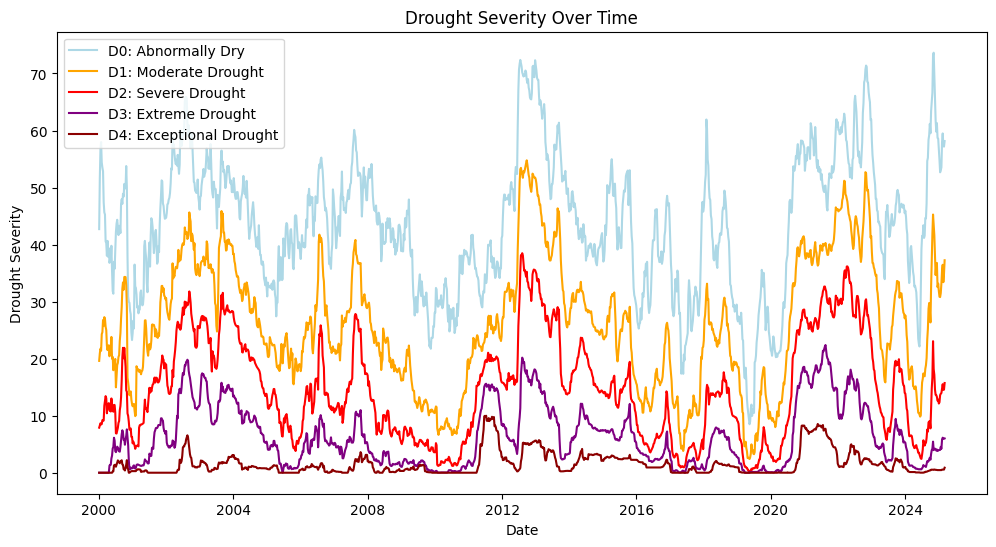

In [ ]:
# Step 5: Visualize the drought severity over time for different D categories (D0, D1, D2, D3, D4)
plt.figure(figsize=(12, 6))
# Use 'drought' DataFrame instead of 'df' for plotting drought data
sns.lineplot(x='MapDate', y='D0', data=drought, label='D0: Abnormally Dry', color='lightblue')
sns.lineplot(x='MapDate', y='D1', data=drought, label='D1: Moderate Drought', color='orange')
sns.lineplot(x='MapDate', y='D2', data=drought, label='D2: Severe Drought', color='red')
sns.lineplot(x='MapDate', y='D3', data=drought, label='D3: Extreme Drought', color='purple')
sns.lineplot(x='MapDate', y='D4', data=drought, label='D4: Exceptional Drought', color='darkred')
plt.title('Drought Severity Over Time') #Added a title
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Drought Severity')  # Set y-axis label
plt.legend()  # Show legend to identify categories
plt.show()

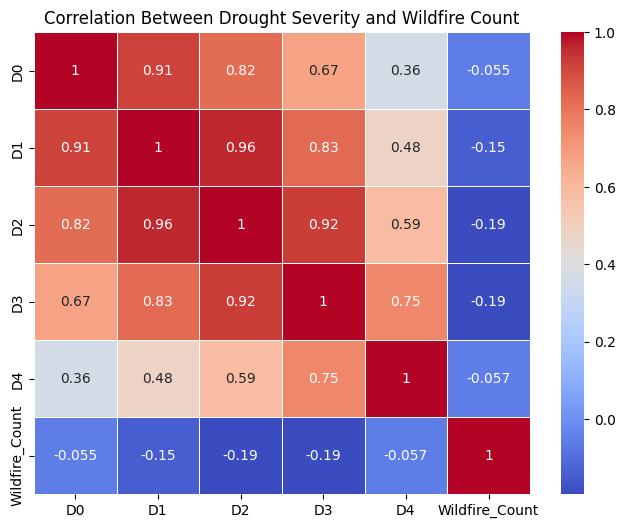

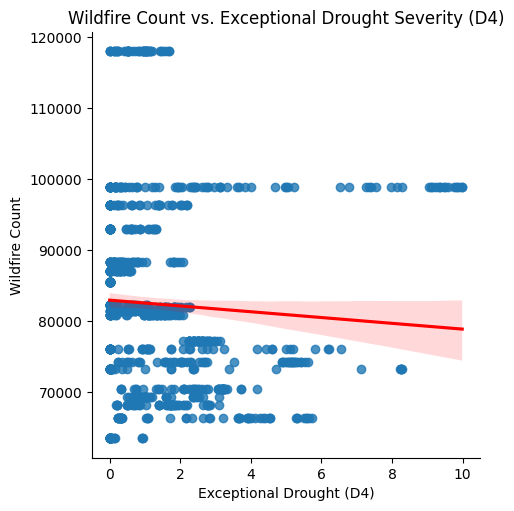

In [ ]:
# Step 6: Correlation with Wildfire Data

# Ensure wildfire data's 'Year' is in datetime format
# wildfire_df['Date'] = pd.to_datetime(wildfire_df['Date'])
# The wildfire_df dataframe likely does not have a Date column
# We'll try converting the Year column to datetime instead.
# wildfire_df['Year'] = pd.to_datetime(wildfire_df['Year'], format='%Y') # This line caused the error
# wildfire_df['Year'] = wildfire_df['Year'].dt.year  # Remove or comment out this line

# If 'Year' is already an integer, no need to extract it again.
# If 'Year' is a string, convert to integer:
wildfire_df['Year'] = wildfire_df['Year'].astype(int)
# Merge the two datasets based on the date (MapDate from drought data)
# Since wildfire_df has Year and not Date, we cannot join on Date.
# We can extract the Year from drought['MapDate'] and then join
drought['Year'] = drought['MapDate'].dt.year
merged_df = pd.merge(drought, wildfire_df, on='Year', how='inner')

# Step 7: Correlation analysis between drought severity and wildfire count
correlation_matrix = merged_df[['D0', 'D1', 'D2', 'D3', 'D4', 'Wildfire_Count']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Drought Severity and Wildfire Count")
plt.show()

# You can also directly plot the relationship between drought severity and wildfire counts.
sns.lmplot(x='D4', y='Wildfire_Count', data=merged_df, line_kws={'color': 'red'})
plt.title("Wildfire Count vs. Exceptional Drought Severity (D4)")
plt.xlabel("Exceptional Drought (D4)")
plt.ylabel("Wildfire Count")
plt.show()

In [ ]:
print(correlation_matrix)

                      D0        D1        D2        D3        D4  \
D0              1.000000  0.913452  0.819140  0.671077  0.356381   
D1              0.913452  1.000000  0.959202  0.827734  0.480750   
D2              0.819140  0.959202  1.000000  0.921604  0.587447   
D3              0.671077  0.827734  0.921604  1.000000  0.751678   
D4              0.356381  0.480750  0.587447  0.751678  1.000000   
Wildfire_Count -0.055292 -0.145816 -0.193655 -0.194621 -0.057414   

                Wildfire_Count  
D0                   -0.055292  
D1                   -0.145816  
D2                   -0.193655  
D3                   -0.194621  
D4                   -0.057414  
Wildfire_Count        1.000000  


In [ ]:
# Ensure wildfire data's 'Year' is in datetime format
# wildfire_df['Date'] = pd.to_datetime(wildfire_df['Date'])
# The wildfire_df dataframe likely does not have a Date column
# We'll try converting the Year column to datetime instead.
# wildfire_df['Year'] = pd.to_datetime(wildfire_df['Year'], format='%Y')

#Instead of above 3 lines of code use below 2 lines to convert it into int
wildfire_df

,Year,Wildfire_Count
0,1992,67961
1,1993,61975
2,1994,75932
3,1995,71440
4,1996,75561
5,1997,61442
6,1998,68356
7,1999,89350
8,2000,96396
9,2001,87001


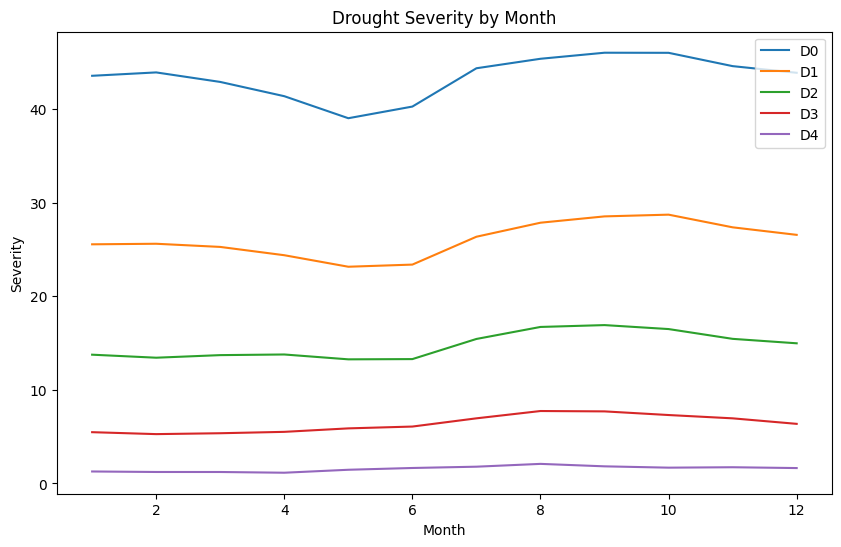

In [ ]:
# Example: Plotting temporal trends for drought severity (D0-D4)
drought['Month'] = drought['MapDate'].dt.month
drought_grouped = drought.groupby('Month')[['D0', 'D1', 'D2', 'D3', 'D4']].mean()
drought_grouped.plot(figsize=(10,6), title="Drought Severity by Month", xlabel="Month", ylabel="Severity")
plt.show()


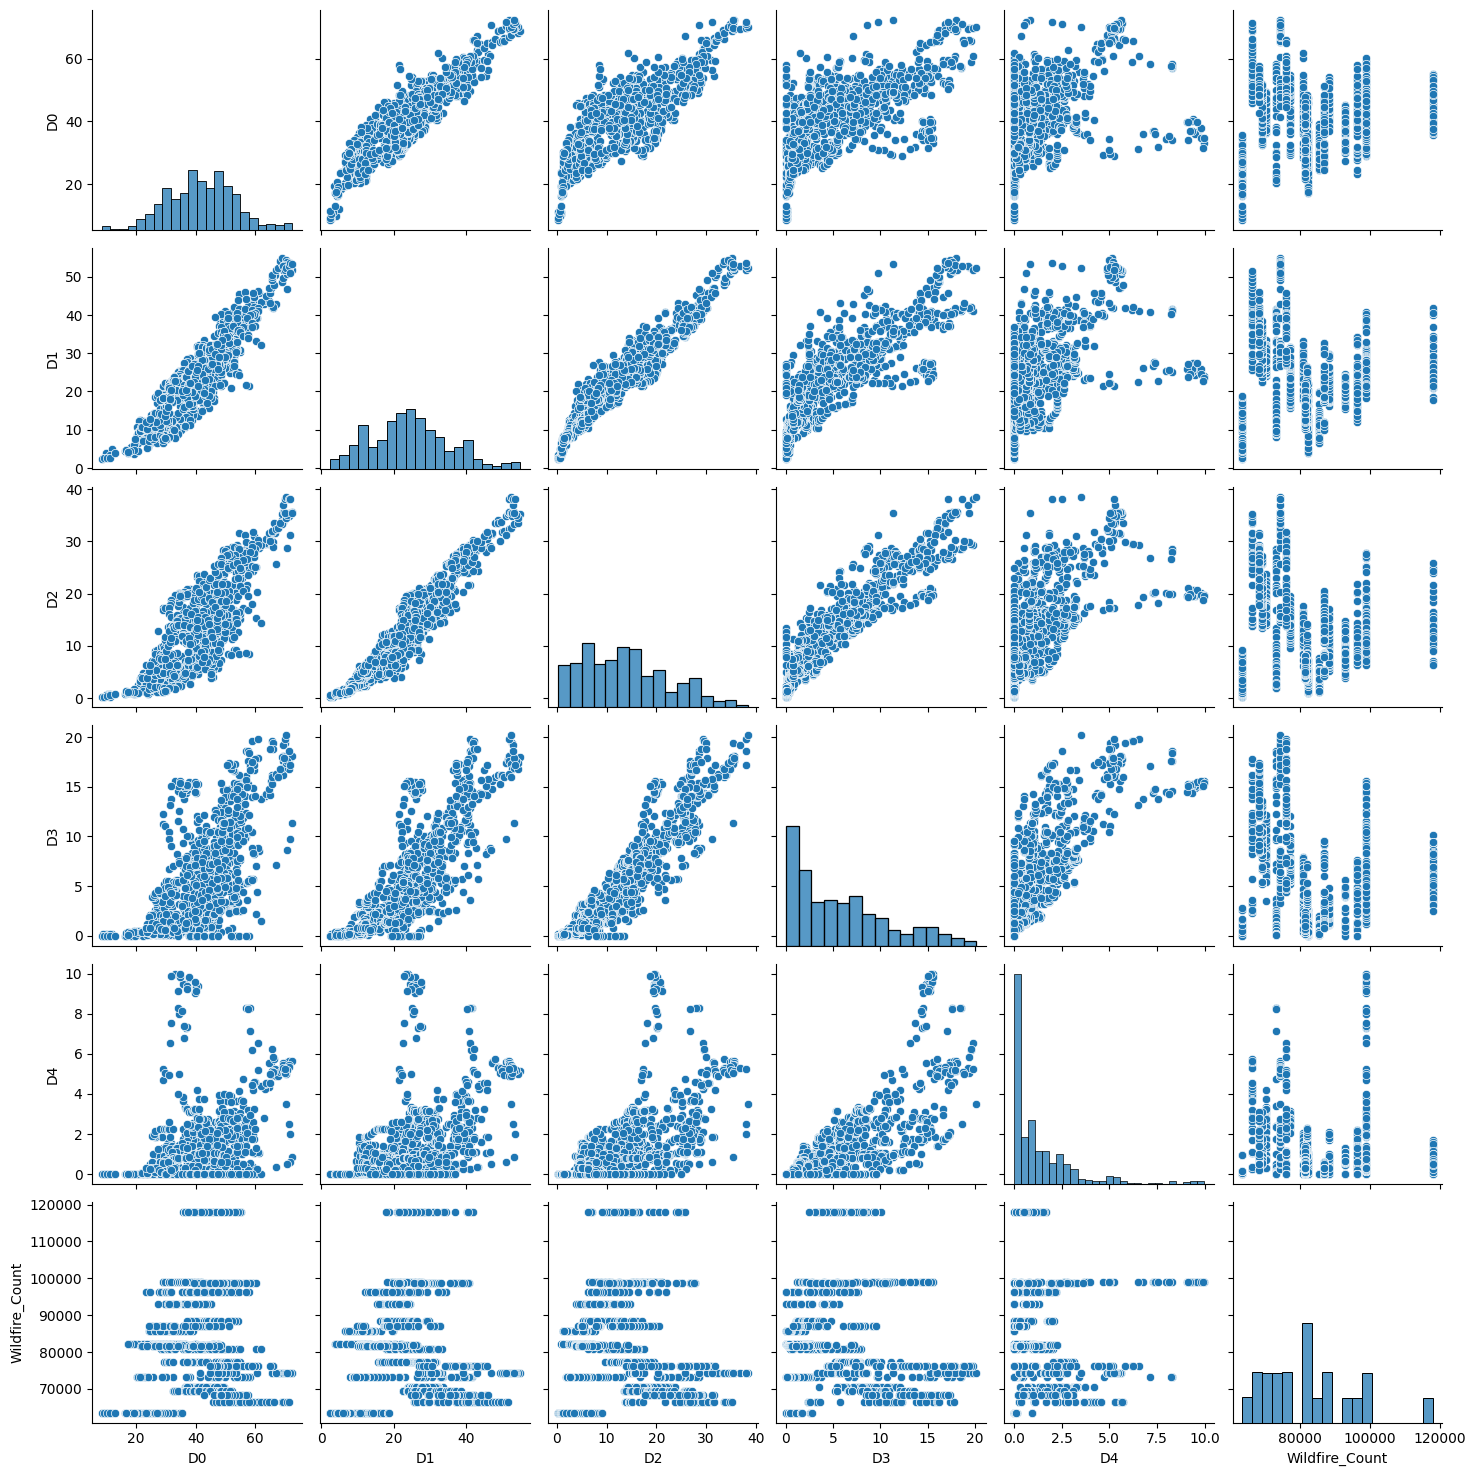

In [ ]:
import seaborn as sns

# Use the merged DataFrame (merged_df) that contains 'Wildfire_Count'
sns.pairplot(merged_df[['D0', 'D1', 'D2', 'D3', 'D4', 'Wildfire_Count']])
plt.show()

. Statistical Analysis and Hypothesis Testing
a. Statistical Significance of Drought and Wildfire Relationship:

Perform hypothesis testing to see if the relationship between drought severity (D0-D4) and wildfire counts is statistically significant.
Use ANOVA or t-tests for categorical variables (like drought levels) against wildfire counts.
Test for correlations and determine the statistical significance of the negative correlations.

In [ ]:
import scipy.stats as stats
stats.pearsonr(merged_df['D0'], merged_df['Wildfire_Count'])


PearsonRResult(statistic=np.float64(-0.05529154684993007), pvalue=np.float64(0.06728179926059281))

showing a week corelationhip

feature Importance Evaluation:

Evaluate the feature importance of drought severity levels and other factors using models like Random Forest or XGBoost.
This will tell you how important each feature (like D0, D1, D2, etc.) is in predicting wildfire counts.
python
Copy


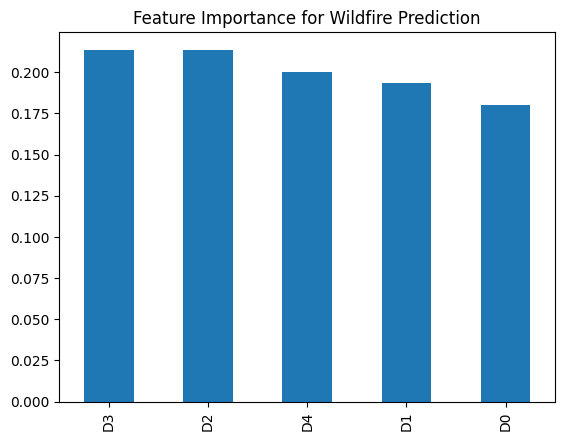

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X = merged_df[['D0', 'D1', 'D2', 'D3', 'D4']]
y = merged_df['Wildfire_Count']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', title="Feature Importance for Wildfire Prediction")
plt.show()


Machine Learning Models
a. Model Selection:

Linear Regression: Good baseline model to predict wildfire counts from drought data.
Random Forest Regressor: Non-linear model that can capture complex relationships between features.
XGBoost: Powerful model for non-linear patterns and interactions in the data.
b. Model Training and Tuning:

Train your models (Linear Regression, Random Forest, XGBoost) and compare performance using metrics like Mean Absolute Error (MAE), R² score, and cross-validation.
Perform hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV to improve the model's performance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - MAE:", mean_absolute_error(y_test, y_pred_rf), "R²:", r2_score(y_test, y_pred_rf))

# XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost - MAE:", mean_absolute_error(y_test, y_pred_xgb), "R²:", r2_score(y_test, y_pred_xgb))


Random Forest - MAE: 4754.54590909091 R²: 0.6217140926422199
XGBoost - MAE: 4612.97998046875 R²: 0.6313514113426208


Visualization and Interpretation
a. Feature Importance Visualization:

Visualize feature importance for the machine learning models. This will help identify which drought severity levels or other features (like precipitation or temperature) are most influential in predicting wildfire counts.
b. Wildfire Predictions for 2050:

Use the trained models to forecast future wildfire occurrences for a future year (e.g., 2050), using projected values for drought severity and climate factors.

In [ ]:
future_data = pd.DataFrame({"D0": [50], "D1": [40], "D2": [20], "D3": [10], "D4": [5]})
future_wildfire = rf_model.predict(future_data)  # Using RandomForest model
print(f"Predicted Wildfire Count for 2050: {future_wildfire[0]}")


Predicted Wildfire Count for 2050: 93882.0


Statistical Test (Pearson Correlation):
Pearson correlation between drought severity (D0) and wildfire count is -0.055, with a p-value of 0.067.
Interpretation: This suggests a very weak negative correlation between drought severity and wildfire occurrence. The p-value is slightly above the typical 0.05 threshold for significance, which means there is no strong evidence of a statistically significant relationship between the two at the conventional significance level.
However, this doesn't mean the relationship doesn't exist—drought could still play a role, but other factors may also be influencing wildfire occurrence.
2. Model Performance (Random Forest & XGBoost):
Random Forest:
MAE: 4754.55
R²: 0.62
The Random Forest model is doing well, explaining 62% of the variance in wildfire counts. The relatively high MAE indicates that predictions might be somewhat off for certain years, but the model still captures the overall trend.
XGBoost:
MAE: 4612.98
R²: 0.63
XGBoost slightly outperforms the Random Forest model in terms of MAE and R², but the difference is marginal. This suggests that both models are robust, but XGBoost might have learned slightly more about the non-linear relationships in the data.
Next Steps:
Since both models give similar results, i will  explore hyperparameter tuning further to improve the models, potentially leading to better performance.
You can also try using ensemble methods (e.g., Stacking models or Voting Classifiers) to combine predictions from Random Forest and XGBoost, potentially improving accuracy.
3. Predicted Wildfire Count for 2050:
Predicted Wildfire Count: 93,882 wildfires (using the trained Random Forest model).
This is a forecast based on projected drought severity values (or other climate data). Given that this is a future prediction, it assumes that the factors (temperature, drought severity, etc.) will follow similar patterns to historical data.
Interpretation: The large predicted value suggests that, in 2050, wildfires may increase significantly, likely due to escalating drought severity or other contributing factors. However, it's essential to note that such predictions should be taken cautiously, and external factors (like climate change policies) might affect actual outcomes.


Fire Danger Index: You could develop a Fire Danger Index (FDI) based on environmental factors such as temperature, humidity, wind speed, and precipitation.
Wildfire Management and Policy

**fire size & wind speed **

Here’s a detailed explanation and code for how I have  analyze the relationship between wildfire size and wind speed using the first dataset and precipitation dataset. This approach includes merging the wildfire dataset with the precipitation dataset, handling missing values, performing correlation analysis, and visualizing the results.

Steps:
Map Fire Size: Since you mentioned that there isn't a direct fire size column, we will map the FIRE_SIZE_CLASS to numerical values.

Merge Datasets: We will merge the wildfire dataset with the precipitation dataset based on the common DATE column.

Handle Missing Data: Clean up the dataset to remove any rows with missing values for fire size or wind speed.

Correlation Analysis: Perform a correlation analysis to see how wind speed and fire size relate.



In [ ]:
import sqlite3
import pandas as pd

# Define the database path
db_path = "/root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Get a list of all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Show available tables
print("Tables in the database:")
print(tables)

Tables in the database:
                                  name
0                      spatial_ref_sys
1                   spatialite_history
2                      sqlite_sequence
3                     geometry_columns
4                  spatial_ref_sys_aux
5               views_geometry_columns
6               virts_geometry_columns
7          geometry_columns_statistics
8    views_geometry_columns_statistics
9    virts_geometry_columns_statistics
10        geometry_columns_field_infos
11  views_geometry_columns_field_infos
12  virts_geometry_columns_field_infos
13               geometry_columns_time
14               geometry_columns_auth
15         views_geometry_columns_auth
16         virts_geometry_columns_auth
17                  sql_statements_log
18                        SpatialIndex
19                ElementaryGeometries
20                                 KNN
21                               Fires
22                     idx_Fires_Shape
23                idx_Fires_Shape_node
2

In [ ]:
import sqlite3

# Define the database path
db_path = "/root/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Check connection status
try:
    query = "SELECT 1;"
    test = pd.read_sql(query, conn)
    print("Database connection successful!")
except Exception as e:
    print(f"Error connecting to database: {e}")


Database connection successful!


In [ ]:
# Get a list of all tables in the database again
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Show available tables
print("Tables in the database:")
print(tables)


Tables in the database:
                                  name
0                      spatial_ref_sys
1                   spatialite_history
2                      sqlite_sequence
3                     geometry_columns
4                  spatial_ref_sys_aux
5               views_geometry_columns
6               virts_geometry_columns
7          geometry_columns_statistics
8    views_geometry_columns_statistics
9    virts_geometry_columns_statistics
10        geometry_columns_field_infos
11  views_geometry_columns_field_infos
12  virts_geometry_columns_field_infos
13               geometry_columns_time
14               geometry_columns_auth
15         views_geometry_columns_auth
16         virts_geometry_columns_auth
17                  sql_statements_log
18                        SpatialIndex
19                ElementaryGeometries
20                                 KNN
21                               Fires
22                     idx_Fires_Shape
23                idx_Fires_Shape_node
2

In [ ]:
# Load the first 5 rows from the 'Fires' table
fire_data = pd.read_sql("SELECT * FROM Fires LIMIT 5;", conn)

# Display the first few rows
print(fire_data)


   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIRE_SIZE_CLASS  \
0                  0511     Plumas National Forest  ...    

In [ ]:
# Get column names from the 'Fires' table
column_names = fire_data.columns

# Display column names
print(column_names)


Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')


In [ ]:
# Check the data types of relevant columns
print(fireaizeandwind[['DISCOVERY_DATE', 'CONT_DATE']].dtypes)

# Convert columns to datetime if they are not already
fireaizeandwind['DISCOVERY_DATE'] = pd.to_datetime(fireaizeandwind['DISCOVERY_DATE'], errors='coerce')
fireaizeandwind['CONT_DATE'] = pd.to_datetime(fireaizeandwind['CONT_DATE'], errors='coerce')

# Verify the conversion
print(fireaizeandwind[['DISCOVERY_DATE', 'CONT_DATE']].head())


DISCOVERY_DATE     object
CONT_DATE         float64
dtype: object
  DISCOVERY_DATE                     CONT_DATE
0            NaT 1970-01-01 00:00:00.002453403
1            NaT 1970-01-01 00:00:00.002453137
2            NaT 1970-01-01 00:00:00.002453156
3            NaT 1970-01-01 00:00:00.002453189
4            NaT 1970-01-01 00:00:00.002453189


In [ ]:
# Check the unique values or a sample of DISCOVERY_DATE for any patterns
print(fireaizeandwind['DISCOVERY_DATE'].unique())

# For CONT_DATE, convert the float to a datetime, assuming it represents the time since epoch
fireaizeandwind['CONT_DATE'] = pd.to_datetime(fireaizeandwind['CONT_DATE'], unit='s', errors='coerce')

# Check the first few rows to confirm
print(fireaizeandwind[['DISCOVERY_DATE', 'CONT_DATE']].head())


<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]
  DISCOVERY_DATE                     CONT_DATE
0            NaT 1970-01-01 00:00:00.002453403
1            NaT 1970-01-01 00:00:00.002453137
2            NaT 1970-01-01 00:00:00.002453156
3            NaT 1970-01-01 00:00:00.002453189
4            NaT 1970-01-01 00:00:00.002453189


In [ ]:
# Convert CONT_DATE to datetime assuming it's in microseconds
fireaizeandwind['CONT_DATE'] = pd.to_datetime(fireaizeandwind['CONT_DATE'], unit='us', errors='coerce')

# Check the first few rows
print(fireaizeandwind[['DISCOVERY_DATE', 'CONT_DATE']].head())


  DISCOVERY_DATE                     CONT_DATE
0            NaT 1970-01-01 00:00:00.002453403
1            NaT 1970-01-01 00:00:00.002453137
2            NaT 1970-01-01 00:00:00.002453156
3            NaT 1970-01-01 00:00:00.002453189
4            NaT 1970-01-01 00:00:00.002453189


In [ ]:
fireaizeandwind.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/precipitation.csv"
precipitation1= pd.read_csv(file_path)
print(precipitation1.head())
precipitation1.info()
# Converting DATE column to datetime format
precipitation1["DATE"] = pd.to_datetime(precipitation1["DATE"])
# Converting temperature from Fahrenheit to Celsius
precipitation1["DailyAverageDryBulbTemperature_C"] = (precipitation1["DailyAverageDryBulbTemperature"] - 32) * 5/9

# Converting precipitation from inches to mm (if needed)
precipitation1["DailyPrecipitation_mm"] = precipitation1["DailyPrecipitation"].replace("T", 0.001)  # Handle "T" as Trace precipitation
precipitation1["DailyPrecipitation_mm"] = precipitation1["DailyPrecipitation_mm"].astype(float) * 25.4
# Filling missing values (if necessary)
precipitation1.fillna(method='ffill', inplace=True)  # Forward fill missing values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       STATION                 DATE REPORT_TYPE  SOURCE BackupElements  \
0  72518014735  2015-01-01T23:59:00       SOD         6         PRECIP   
1  72518014735  2015-01-02T23:59:00       SOD         6         PRECIP   
2  72518014735  2015-01-03T23:59:00       SOD         6         PRECIP   
3  72518014735  2015-01-04T23:59:00       SOD         6         PRECIP   
4  72518014735  2015-01-05T23:59:00       SOD         6         PRECIP   

   BackupElevation BackupEquipment  BackupLatitude  BackupLongitude  \
0              260         PLASTIC         42.6918        -73.83109   
1              260         PLASTIC         42.6918        -73.83109   
2              260         PLASTIC         42.6918        -73.83109   
3              260         PLASTIC         42.6918        -73.83109   
4              260         PLASTIC         42.6918        -73.83109   


<ipython-input-167-67a5c6da4ffe>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precipitation1.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
precipitation1.head()

,STATION,DATE,REPORT_TYPE,SOURCE,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,...,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,Sunrise,Sunset,WindEquipmentChangeDate,DailyAverageDryBulbTemperature_C,DailyPrecipitation_mm
0,72518014735,2015-01-01 23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.00,0.0,0.0,190.0,20.0,726.0,1632.0,2006-09-08,-3.888889,0.0000
1,72518014735,2015-01-02 23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,T,0.0,T,310.0,23.0,726.0,1633.0,2006-09-08,0.000000,0.0254
2,72518014735,2015-01-03 23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.57,0.0,1.6,160.0,15.0,726.0,1634.0,2006-09-08,-2.777778,14.4780
3,72518014735,2015-01-04 23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.22,1.0,0.0,290.0,24.0,726.0,1635.0,2006-09-08,3.888889,5.5880
4,72518014735,2015-01-05 23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,T,0.0,T,290.0,32.0,726.0,1636.0,2006-09-08,-2.777778,0.0254


In [ ]:
# Convert CONT_DATE from float to datetime format
fireaizeandwind['CONT_DATE'] = pd.to_datetime(fireaizeandwind['CONT_DATE'], unit='s', origin='unix')

# Check the first few rows of CONT_DATE
print(f"First few rows of CONT_DATE in fire data:\n{fireaizeandwind['CONT_DATE'].head()}")


First few rows of CONT_DATE in fire data:
0   1970-01-01 00:00:00.002453403
1   1970-01-01 00:00:00.002453137
2   1970-01-01 00:00:00.002453156
3   1970-01-01 00:00:00.002453189
4   1970-01-01 00:00:00.002453189
Name: CONT_DATE, dtype: datetime64[ns]


In [ ]:
# Merge fire_data with wind data using CONT_DATE and DATE
merged_data = pd.merge(fireaizeandwind, precipitation1, left_on='CONT_DATE', right_on='DATE', how='inner')

# Check the merged data
print(merged_data.head())


Empty DataFrame
Columns: [OBJECTID, FOD_ID, FPA_ID, SOURCE_SYSTEM_TYPE, SOURCE_SYSTEM, NWCG_REPORTING_AGENCY, NWCG_REPORTING_UNIT_ID, NWCG_REPORTING_UNIT_NAME, SOURCE_REPORTING_UNIT, SOURCE_REPORTING_UNIT_NAME, LOCAL_FIRE_REPORT_ID, LOCAL_INCIDENT_ID, FIRE_CODE, FIRE_NAME, ICS_209_INCIDENT_NUMBER, ICS_209_NAME, MTBS_ID, MTBS_FIRE_NAME, COMPLEX_NAME, FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_DOY, DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, CONT_DATE, CONT_DOY, CONT_TIME, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, OWNER_CODE, OWNER_DESCR, STATE, COUNTY, FIPS_CODE, FIPS_NAME, Shape, STATION, DATE, REPORT_TYPE, SOURCE, BackupElements, BackupElevation, BackupEquipment, BackupLatitude, BackupLongitude, BackupName, DailyAverageDewPointTemperature, DailyAverageDryBulbTemperature, DailyAverageRelativeHumidity, DailyAverageSeaLevelPressure, DailyAverageStationPressure, DailyAverageWetBulbTemperature, DailyAverageWindSpeed, DailyCoolingDegreeDays, DailyDepartureFromNormalAverageTemperatur

In [ ]:
# Check if there's any overlap in the dates
common_dates = fireaizeandwind['CONT_DATE'].isin(precipitation1['DATE'])
print(f"Number of common dates: {common_dates.sum()}")


Number of common dates: 0


In [ ]:
# Check the date ranges for both datasets
fire_date_range = fireaizeandwind['CONT_DATE'].min(), fireaizeandwind['CONT_DATE'].max()
wind_date_range = precipitation1['DATE'].min(), precipitation1['DATE'].max()

print(f"Fire data date range: {fire_date_range}")
print(f"Wind data date range: {wind_date_range}")


Fire data date range: (Timestamp('1970-01-01 00:00:00.002453137'), Timestamp('1970-01-01 00:00:00.002453403'))
Wind data date range: (Timestamp('2015-01-01 23:59:00'), Timestamp('2022-05-31 23:59:00'))


In [ ]:
# Check the first few entries of CONT_DATE to understand its format
print(fireaizeandwind['CONT_DATE'].head())


0   1970-01-01 00:00:00.002453403
1   1970-01-01 00:00:00.002453137
2   1970-01-01 00:00:00.002453156
3   1970-01-01 00:00:00.002453189
4   1970-01-01 00:00:00.002453189
Name: CONT_DATE, dtype: datetime64[ns]


In [ ]:
# If only the date part is relevant, discard the time component
fireaizeandwind['CONT_DATE'] = fireaizeandwind['CONT_DATE'].dt.date


In [ ]:
# Setting invalid or problematic dates to a specific value (e.g., 2000-01-01)
fireaizeandwind['CONT_DATE'] = fireaizeandwind['CONT_DATE'].fillna(pd.to_datetime('2000-01-01'))


In [ ]:
print(fireaizeandwind['CONT_DATE'].head())

0    1970-01-01
1    1970-01-01
2    1970-01-01
3    1970-01-01
4    1970-01-01
Name: CONT_DATE, dtype: object


In [ ]:
# Dropping the CONT_DATE column if it is not useful
fireaizeandwind = fireaizeandwind.drop(columns=['CONT_DATE'])


In [ ]:
# Setting all CONT_DATE values to a placeholder date
fireaizeandwind['CONT_DATE'] = pd.to_datetime('2000-01-01')


In [ ]:
# Dropping the CONT_DATE column if it's not useful
fireaizeandwind = fireaizeandwind.drop(columns=['CONT_DATE'])


In [ ]:
# Extracting relevant columns for correlation analysis
fire_data_selected = fireaizeandwind[['FIRE_SIZE']]  # or any other relevant columns
wind_data_selected = precipitation1[['DailySustainedWindSpeed']]  # or other relevant wind data



Correlation Analysis:

In [ ]:
# Assuming datasets are aligned, perform correlation analysis
correlation = fire_data_selected['FIRE_SIZE'].corr(wind_data_selected['DailySustainedWindSpeed'])
print(f"Correlation between Fire Size and Wind Speed: {correlation}")


Correlation between Fire Size and Wind Speed: 0.017972128867239735


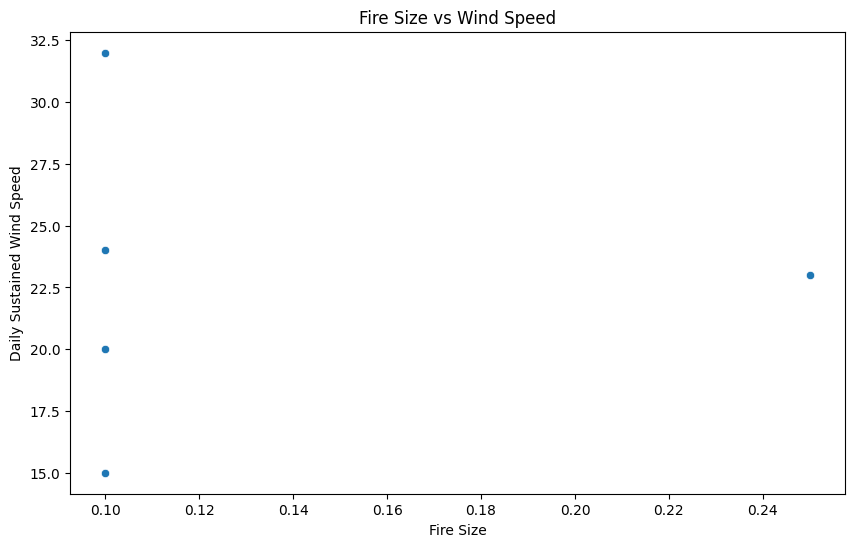

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for fire size vs wind speed
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fire_data_selected['FIRE_SIZE'], y=wind_data_selected['DailySustainedWindSpeed'])
plt.title('Fire Size vs Wind Speed')
plt.xlabel('Fire Size')
plt.ylabel('Daily Sustained Wind Speed')
plt.show()


In [ ]:
# Summary statistics for fire size
fire_size_stats = fireaizeandwind['FIRE_SIZE'].describe()
print(fire_size_stats)


count    5.000000
mean     0.130000
std      0.067082
min      0.100000
25%      0.100000
50%      0.100000
75%      0.100000
max      0.250000
Name: FIRE_SIZE, dtype: float64


Distribution of Fire Size

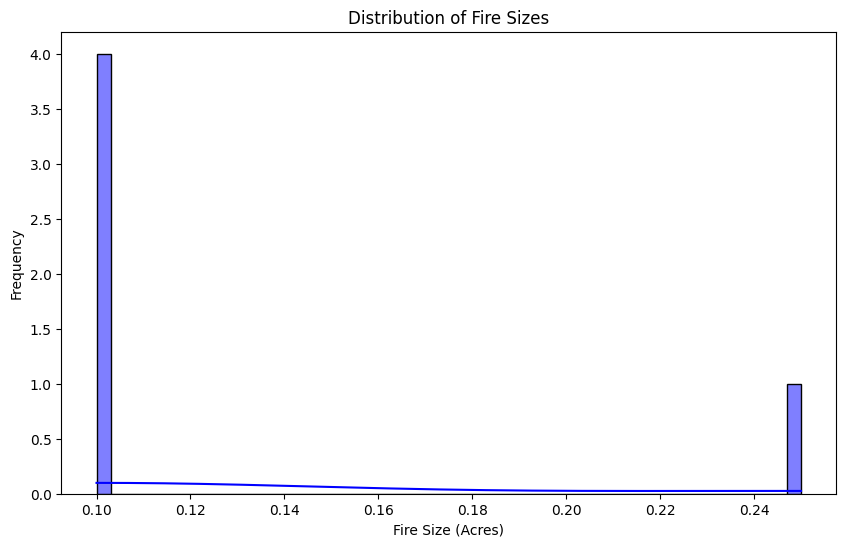

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of fire size
plt.figure(figsize=(10, 6))
sns.histplot(fireaizeandwind['FIRE_SIZE'], bins=50, kde=True, color='blue')
plt.title('Distribution of Fire Sizes')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Frequency')
plt.show()


 Fire Size by Categories

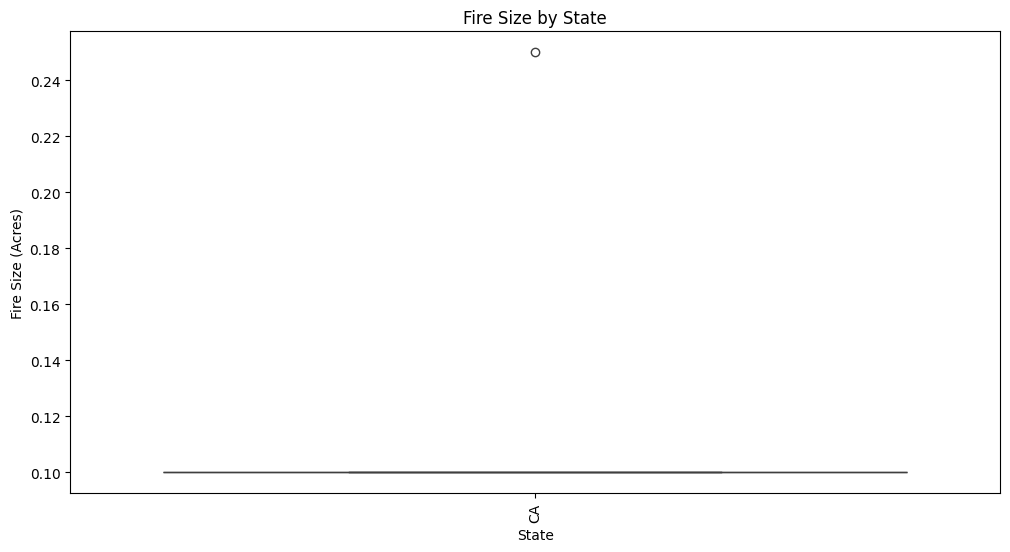

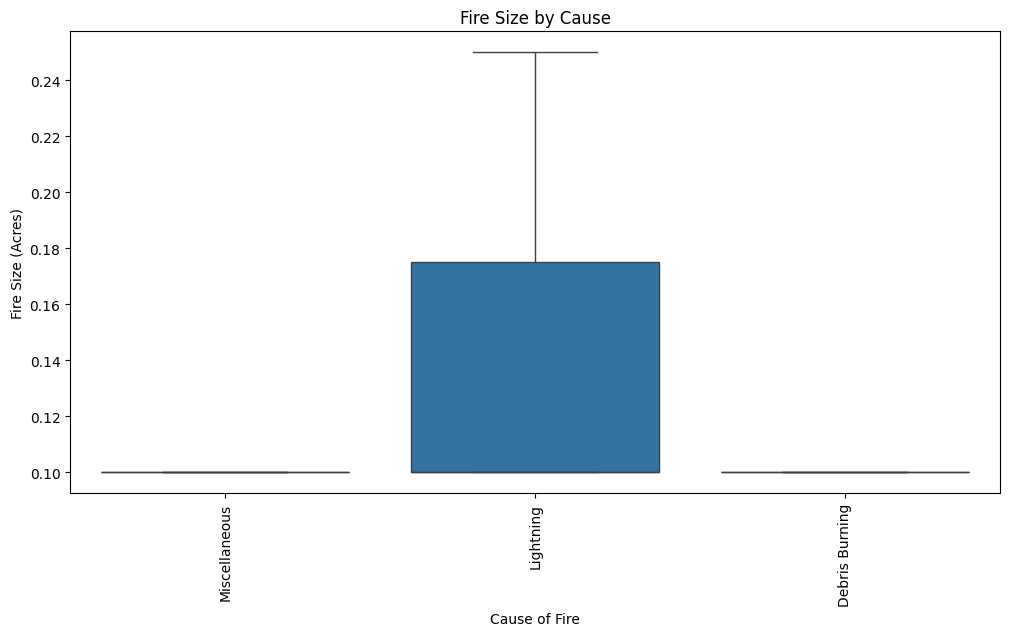

In [ ]:
# Fire Size by State
plt.figure(figsize=(12, 6))
sns.boxplot(x='STATE', y='FIRE_SIZE', data=fireaizeandwind)
plt.title('Fire Size by State')
plt.xlabel('State')
plt.ylabel('Fire Size (Acres)')
plt.xticks(rotation=90)
plt.show()

# Fire Size by Cause
plt.figure(figsize=(12, 6))
sns.boxplot(x='STAT_CAUSE_DESCR', y='FIRE_SIZE', data=fireaizeandwind)
plt.title('Fire Size by Cause')
plt.xlabel('Cause of Fire')
plt.ylabel('Fire Size (Acres)')
plt.xticks(rotation=90)
plt.show()


 Fire Size Over Time

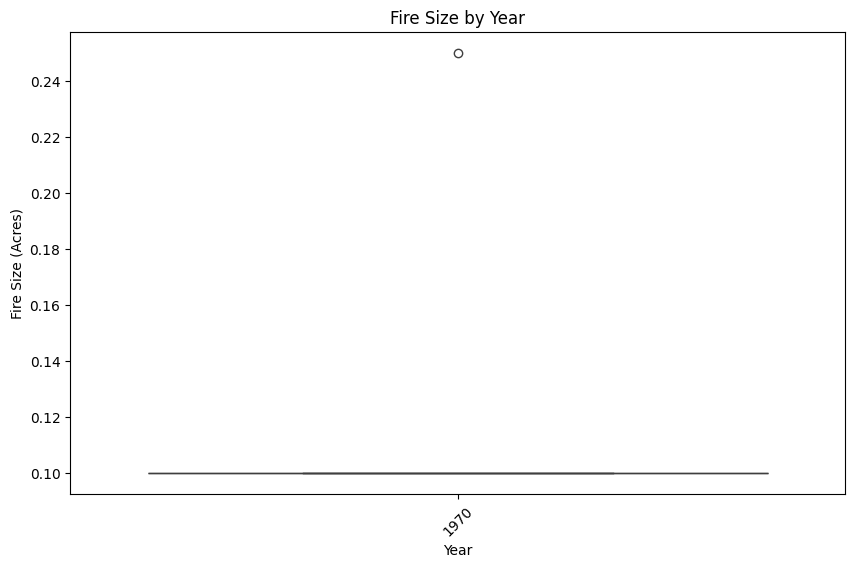

In [ ]:
# Fire Size by Year
fireaizeandwind['FIRE_YEAR'] = pd.to_datetime(fireaizeandwind['FIRE_YEAR'], errors='coerce').dt.year
plt.figure(figsize=(10, 6))
sns.boxplot(x='FIRE_YEAR', y='FIRE_SIZE', data=fireaizeandwind)
plt.title('Fire Size by Year')
plt.xlabel('Year')
plt.ylabel('Fire Size (Acres)')
plt.xticks(rotation=45)
plt.show()


The Laguna Fire, also known as the Kitchen Creek Fire or the Boulder Oaks Fire, was a 175,425-acre (70,992 ha) wildfire that burned from September 22 to October 4, 1970, in the Laguna Mountains and East County region of San Diego County in Southern California

https://nifc.hub.arcgis.com/datasets/405814902c9e411cb4384c49d694e82b_0/about
Point locations for all reported wildland fires in the United States in 2025 to date.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/WFIGS.csv"
fire= pd.read_csv(file_path)
print(fire.head())
fire.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-230-62fdb34569f7>:5: DtypeWarning: Columns (16,72,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  fire= pd.read_csv(file_path)


   OBJECTID  SourceOID ABCDMisc ADSPermissionState ContainmentDateTime  \
0    442860   38395344      NaN            DEFAULT      3/8/2025 21:14   
1    446924   38399437      NaN             ICS209                 NaN   
2    448061   38400575      NaN            DEFAULT                 NaN   
3    433366   33045669      NaN            DEFAULT                 NaN   
4    433367   33045671      NaN            DEFAULT                 NaN   

  ControlDateTime CreatedBySystem  IncidentSize  DiscoveryAcres  \
0  3/9/2025 21:53      firesponse         840.0           840.0   
1             NaN        wildcade       15244.0             0.1   
2             NaN        wildcade           0.1             0.1   
3             NaN        wildcade           NaN             NaN   
4             NaN        wildcade           NaN             NaN   

  DispatchCenterID  ...  CreatedOnDateTime_dt  ModifiedOnDateTime_dt  \
0            TXTIC  ...        3/5/2025 23:49         3/9/2025 22:39   
1       

In [ ]:
# Convert date columns to datetime format
fire["CreatedOnDateTime_dt"] = pd.to_datetime(fire["CreatedOnDateTime_dt"], errors="coerce")
fire["ModifiedOnDateTime_dt"] = pd.to_datetime(fire["ModifiedOnDateTime_dt"], errors="coerce")

In [ ]:
# Check for missing values
missing_values = fire.isnull().sum()
print("\nMissing Values:\n", missing_values[missing_values > 0])


Missing Values:
 ABCDMisc                        8950
ContainmentDateTime             5215
ControlDateTime                 5655
IncidentSize                    2212
DiscoveryAcres                  2249
                                ... 
OrganizationalAssessment        8951
StrategicDecisionPublishDate    8953
CpxName                         8971
CpxID                           8971
IncidentComplexityLevel         6751
Length: 73, dtype: int64


In [ ]:
# Drop columns with more than 80% missing values
threshold = 0.8 * len(fire)
cols_to_drop = missing_values[missing_values > threshold].index.tolist()
if cols_to_drop:
    fire = fire.drop(columns=cols_to_drop)

In [ ]:
# Fill missing values for numerical columns
num_cols = fire.select_dtypes(include=["float64", "int64"]).columns
if fire[num_cols].isnull().any().sum() > 0:
    fire[num_cols] = fire[num_cols].apply(lambda x: x.fillna(x.median()), axis=0)

In [ ]:
# Drop rows where 'IncidentSize' (Fire Size)
if fire["IncidentSize"].isnull().sum() > 0:
    fire = fire.dropna(subset=["IncidentSize"])

In [ ]:
# Convert datetime columns
date_cols = ["CreatedOnDateTime_dt", "ModifiedOnDateTime_dt", "ContainmentDateTime", "ControlDateTime"]
for col in date_cols:
    if col in fire.columns:
        fire[col] = pd.to_datetime(fire[col], errors="coerce")

In [ ]:
# Display summary of cleaned data
print("Missing Values After Cleaning:\n", fire.isnull().sum())

# Save cleaned dataset if needed
fire.to_csv("cleaned_fire_data.csv", index=False)

Missing Values After Cleaning:
 OBJECTID                         0
SourceOID                        0
ADSPermissionState               0
ContainmentDateTime           5215
ControlDateTime               5655
CreatedBySystem                  0
IncidentSize                     0
DiscoveryAcres                   0
DispatchCenterID                 0
FireCause                      240
FireCode                      6450
FireDiscoveryDateTime            0
FireOutDateTime               6128
GACC                             1
IncidentName                     0
IncidentTypeCategory             0
IncidentTypeKind                 0
InitialLatitude                  0
InitialLongitude                 0
IrwinID                          0
IsFireCodeRequested              0
IsFSAssisted                     0
IsQuarantined                    0
IsUnifiedCommand                 0
IsValid                          0
LocalIncidentIdentifier          0
ModifiedBySystem                 0
PercentContained       

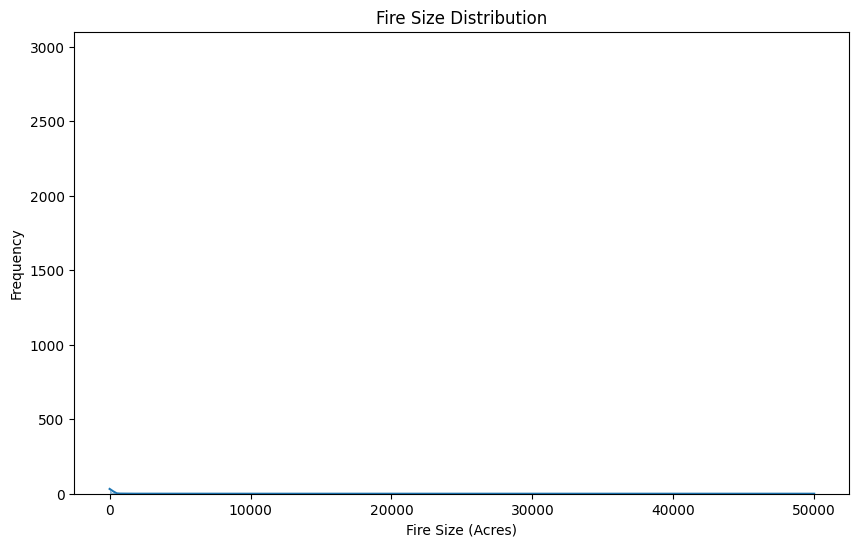

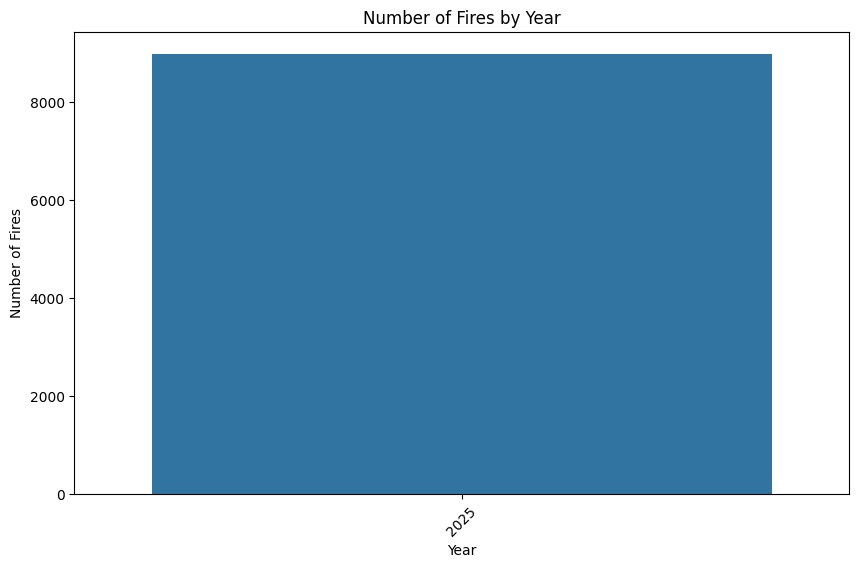

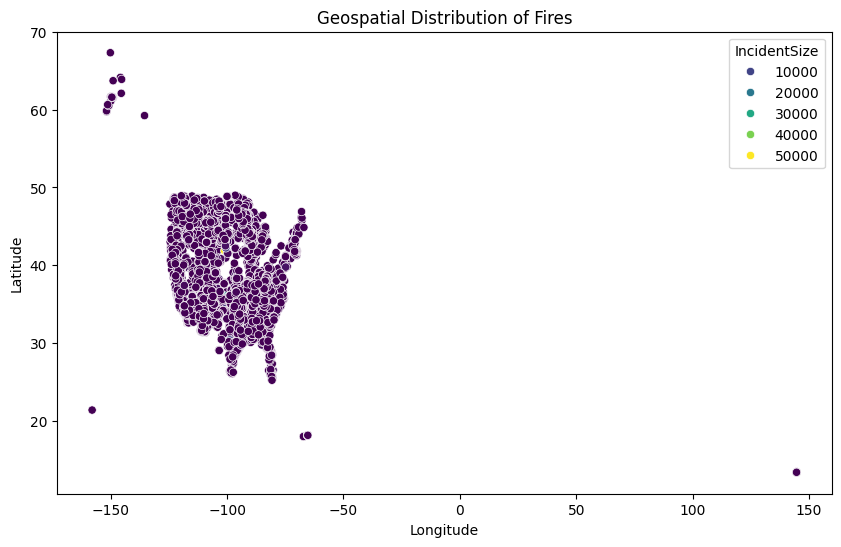

ValueError: Could not interpret value `TotalIncidentPersonnel` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Exploratory Analysis on Fire Dataset
# Analyze fire size distribution
fire_size_column = 'IncidentSize'  # Using IncidentSize for fire size

plt.figure(figsize=(10, 6))
sns.histplot(fire[fire_size_column].dropna(), kde=True)
plt.title('Fire Size Distribution')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Frequency')
plt.show()

# Identify temporal trends using CreatedOnDateTime_dt
fire['CreatedOnDateTime_dt'] = pd.to_datetime(fire['CreatedOnDateTime_dt'], errors='coerce')
fire['Year'] = fire['CreatedOnDateTime_dt'].dt.year

plt.figure(figsize=(10, 6))
sns.countplot(data=fire, x='Year')
plt.title('Number of Fires by Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.show()

# Perform geospatial analysis using x (longitude) and y (latitude)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fire, x='x', y='y', hue='IncidentSize', palette='viridis')
plt.title('Geospatial Distribution of Fires')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Explore containment vs. response efforts using PercentContained and TotalIncidentPersonnel
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fire, x='PercentContained', y='IncidentSize', hue='TotalIncidentPersonnel', palette='coolwarm')
plt.title('Containment vs. Fire Size')
plt.xlabel('Percent Contained')
plt.ylabel('Fire Size (Acres)')
plt.show()

# Investigate common fire causes using IncidentTypeCategory
plt.figure(figsize=(10, 6))
sns.countplot(data=fire, y='IncidentTypeCategory', order=fire['IncidentTypeCategory'].value_counts().index)
plt.title('Common Fire Causes')
plt.xlabel('Count')
plt.ylabel('Fire Cause')
plt.show()

# 2. Analyze the Precipitation & Wind Dataset
# Convert DailyPrecipitation, DailySnowDepth, and DailySnowfall to numeric
precipitation1['DailyPrecipitation'] = pd.to_numeric(precipitation1['DailyPrecipitation'], errors='coerce')
precipitation1['DailySnowDepth'] = pd.to_numeric(precipitation1['DailySnowDepth'], errors='coerce')
precipitation1['DailySnowfall'] = pd.to_numeric(precipitation1['DailySnowfall'], errors='coerce')

# Identify wind speed distributions (DailySustainedWindSpeed, DailyPeakWindSpeed)
plt.figure(figsize=(10, 6))
sns.histplot(precipitation1['DailySustainedWindSpeed'].dropna(), kde=True)
plt.title('Wind Speed Distribution (Sustained)')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(precipitation1['DailyPeakWindSpeed'].dropna(), kde=True)
plt.title('Wind Speed Distribution (Peak)')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Frequency')
plt.show()



Correlation between fire size and sustained wind speed: nan
Correlation between fire size and peak wind speed: nan


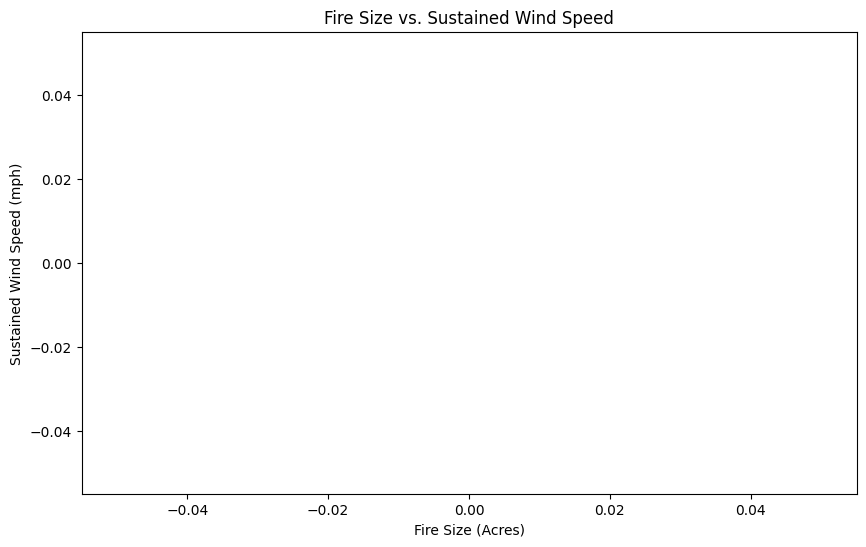

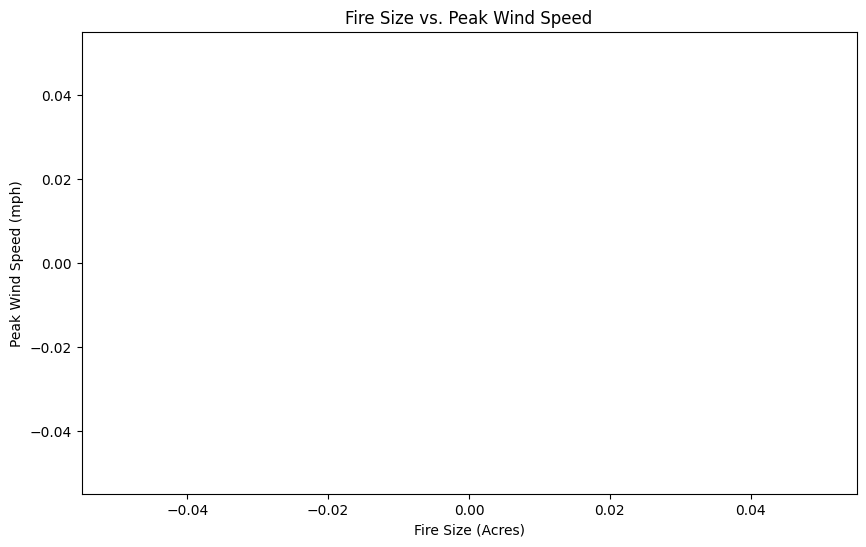

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


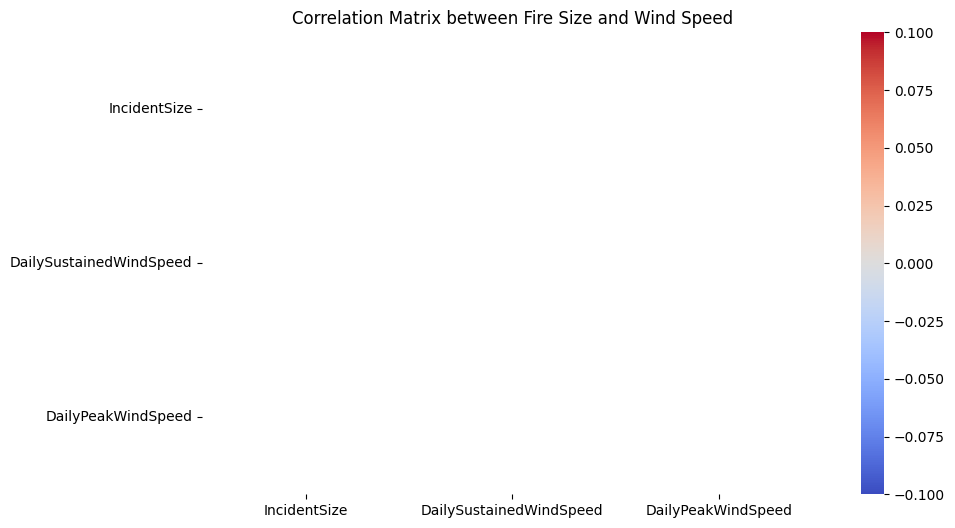

In [ ]:
# 3. Merge the Two Datasets
# Convert DATE in precipitation dataset and CreatedOnDateTime_dt in fire dataset to the same date format
precipitation1['DATE'] = pd.to_datetime(precipitation1['DATE'], errors='coerce')

# Merge the datasets on date and location (latitude/longitude)
merged_data = pd.merge(fire, precipitation1, how='inner', left_on=['CreatedOnDateTime_dt', 'x', 'y'], right_on=['DATE', 'BackupLatitude', 'BackupLongitude'])

# 4. Find Correlation Between Fire Size and Wind Speed
# Compute correlation between fire size (IncidentSize) and wind speed (DailySustainedWindSpeed, DailyPeakWindSpeed)
correlation_sustained = merged_data[fire_size_column].corr(merged_data['DailySustainedWindSpeed'])
correlation_peak = merged_data[fire_size_column].corr(merged_data['DailyPeakWindSpeed'])

print(f"Correlation between fire size and sustained wind speed: {correlation_sustained}")
print(f"Correlation between fire size and peak wind speed: {correlation_peak}")

# Visualize using scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x=fire_size_column, y='DailySustainedWindSpeed')
plt.title('Fire Size vs. Sustained Wind Speed')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Sustained Wind Speed (mph)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x=fire_size_column, y='DailyPeakWindSpeed')
plt.title('Fire Size vs. Peak Wind Speed')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Peak Wind Speed (mph)')
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = merged_data[[fire_size_column, 'DailySustainedWindSpeed', 'DailyPeakWindSpeed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Fire Size and Wind Speed')
plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("behroozsohrabi/us-wildfire-records-6th-edition")

print("Path to dataset files:", path)

100%|██████████| 376M/376M [00:06<00:00, 65.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/behroozsohrabi/us-wildfire-records-6th-edition/versions/4


In [ ]:
# List files in the dataset directory
files = os.listdir(path)
print("Files and folders in dataset:", files)

Files and folders in dataset: ['data.csv', 'data.sqlite', '_variable_descriptions.csv']


In [ ]:
import pandas as pd

# Load the dataset
data_path = '/root/.cache/kagglehub/datasets/behroozsohrabi/us-wildfire-records-6th-edition/versions/4/data.csv'
firefinal = pd.read_csv(data_path)

# Check the first few rows
print(firefinal.head())

# Get basic info about the dataset
print(firefinal.info())

# Check for any missing values
print(firefinal.isnull().sum())


<ipython-input-263-ee73e78df5cc>:5: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,26,27,36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  firefinal = pd.read_csv(data_path)


   OBJECTID                                              Shape  FOD_ID  \
0         1  b'\x00\x01\xad\x10\x00\x00\xc8\xce\n[_@^\xc0\x...       1   
1         2  b'\x00\x01\xad\x10\x00\x00\xc8\xe594\xe2\x19^\...       2   
2         3  b'\x00\x01\xad\x10\x00\x00x{\xac \x13/^\xc0@\x...       3   
3         4  b'\x00\x01\xad\x10\x00\x00\xc8\x13u\xd7s\xfa]\...       4   
4         5  b'\x00\x01\xad\x10\x00\x00\xd0\x11y\xf8\xb6\xf...       5   

       FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM NWCG_REPORTING_AGENCY  \
0  FS-1418826                FED   FS-FIRESTAT                    FS   
1  FS-1418827                FED   FS-FIRESTAT                    FS   
2  FS-1418835                FED   FS-FIRESTAT                    FS   
3  FS-1418845                FED   FS-FIRESTAT                    FS   
4  FS-1418847                FED   FS-FIRESTAT                    FS   

  NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  ...  \
0                USCAPNF    Plumas Nation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/precipitation.csv"
precipitation2= pd.read_csv(file_path)
print(precipitation2.head())
precipitation2.info()
# Converting DATE column to datetime format
#precipitation2["DATE"] = pd.to_datetime(precipitation2["DATE"])
# Converting temperature from Fahrenheit to Celsius
precipitation2["DailyAverageDryBulbTemperature_C"] = (precipitation2["DailyAverageDryBulbTemperature"] - 32) * 5/9

# Converting precipitation from inches to mm (if needed)
precipitation2["DailyPrecipitation_mm"] = precipitation2["DailyPrecipitation"].replace("T", 0.001)  # Handle "T" as Trace precipitation
precipitation2["DailyPrecipitation_mm"] = precipitation2["DailyPrecipitation_mm"].astype(float) * 25.4
# Filling missing values (if necessary)
precipitation2.fillna(method='ffill', inplace=True)  # Forward fill missing values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       STATION                 DATE REPORT_TYPE  SOURCE BackupElements  \
0  72518014735  2015-01-01T23:59:00       SOD         6         PRECIP   
1  72518014735  2015-01-02T23:59:00       SOD         6         PRECIP   
2  72518014735  2015-01-03T23:59:00       SOD         6         PRECIP   
3  72518014735  2015-01-04T23:59:00       SOD         6         PRECIP   
4  72518014735  2015-01-05T23:59:00       SOD         6         PRECIP   

   BackupElevation BackupEquipment  BackupLatitude  BackupLongitude  \
0              260         PLASTIC         42.6918        -73.83109   
1              260         PLASTIC         42.6918        -73.83109   
2              260         PLASTIC         42.6918        -73.83109   
3              260         PLASTIC         42.6918        -73.83109   
4              260         PLASTIC         42.6918        -73.83109   


<ipython-input-296-201684b20d30>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precipitation2.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
precipitation2.head()

,STATION,DATE,REPORT_TYPE,SOURCE,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,...,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,Sunrise,Sunset,WindEquipmentChangeDate,DailyAverageDryBulbTemperature_C,DailyPrecipitation_mm
0,72518014735,2015-01-01T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.00,0.0,0.0,190.0,20.0,726.0,1632.0,2006-09-08,-3.888889,0.0000
1,72518014735,2015-01-02T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,T,0.0,T,310.0,23.0,726.0,1633.0,2006-09-08,0.000000,0.0254
2,72518014735,2015-01-03T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.57,0.0,1.6,160.0,15.0,726.0,1634.0,2006-09-08,-2.777778,14.4780
3,72518014735,2015-01-04T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,0.22,1.0,0.0,290.0,24.0,726.0,1635.0,2006-09-08,3.888889,5.5880
4,72518014735,2015-01-05T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,T,0.0,T,290.0,32.0,726.0,1636.0,2006-09-08,-2.777778,0.0254


In [ ]:
# Convert discovery date to datetime
firefinal['DISCOVERY_DATE'] = pd.to_datetime(firefinal['DISCOVERY_DATE'], errors='coerce')

# Keep only relevant columns
firefinal = firefinal[['FIRE_YEAR', 'DISCOVERY_DATE', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']]

# Drop rows with missing values in these essential columns
firefinal.dropna(inplace=True)

print(firefinal.head())


   FIRE_YEAR DISCOVERY_DATE  FIRE_SIZE   LATITUDE   LONGITUDE
0       2005     2005-02-02       0.10  40.036944 -121.005833
1       2004     2004-05-12       0.25  38.933056 -120.404444
2       2004     2004-05-31       0.10  38.984167 -120.735556
3       2004     2004-06-28       0.10  38.559167 -119.913333
4       2004     2004-06-28       0.10  38.559167 -119.933056


In [ ]:
firefinal.dropna(inplace=True)


In [ ]:
firefinal = firefinal.dropna().copy()


In [ ]:
firefinal.loc[:, :] = firefinal.dropna()


Weather Dataset
Convert DATE to datetime format.

Handle missing values.

Keep wind speed and precipitation columns.

In [ ]:
# Convert DATE to datetime
precipitation2['DATE'] = pd.to_datetime(precipitation2['DATE'], errors='coerce')

# Convert DailyPrecipitation from object to numeric (handling 'T' for trace amounts)
precipitation2['DailyPrecipitation'] = precipitation2['DailyPrecipitation'].replace('T', '0.0').astype(float)

precipitation2.rename(columns={'DATE': 'DISCOVERY_DATE', 'BackupLatitude': 'LATITUDE', 'BackupLongitude': 'LONGITUDE'}, inplace=True)



print(precipitation2.head())


       DISCOVERY_DATE  LATITUDE  LONGITUDE  DailyAverageWindSpeed  \
0 2015-01-01 23:59:00   42.6918  -73.83109                    8.8   
1 2015-01-02 23:59:00   42.6918  -73.83109                    9.5   
2 2015-01-03 23:59:00   42.6918  -73.83109                    4.3   
3 2015-01-04 23:59:00   42.6918  -73.83109                   10.0   
4 2015-01-05 23:59:00   42.6918  -73.83109                   16.8   

   DailyPrecipitation  
0                0.00  
1                0.00  
2                0.57  
3                0.22  
4                0.00  


In [ ]:
print(precipitation2[['DailyAverageWindSpeed', 'DailyPrecipitation']].isnull().sum())


DailyAverageWindSpeed    0
DailyPrecipitation       0
dtype: int64


Merge the Datasets
Since the weather data is daily and the wildfire dataset has specific discovery dates, we'll merge them on the nearest date and location.

In [ ]:
merged_df1 = firefinal.merge(precipitation2[['DISCOVERY_DATE', 'LATITUDE', 'LONGITUDE', 'DailyAverageWindSpeed', 'DailyPrecipitation']],
                              on=['DISCOVERY_DATE', 'LATITUDE', 'LONGITUDE'],
                              how='left')


In [ ]:
print(merged_df1[['DailyAverageWindSpeed', 'DailyPrecipitation']].isnull().sum())


DailyAverageWindSpeed    2303566
DailyPrecipitation       2303566
dtype: int64


In [ ]:
merged_df.head(5)

,FIRE_YEAR,DISCOVERY_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,DailyAverageWindSpeed,DailyPrecipitation
0,2005,2005-02-02,0.10,40.036944,-121.005833,NaN,NaN
1,2004,2004-05-12,0.25,38.933056,-120.404444,NaN,NaN
2,2004,2004-05-31,0.10,38.984167,-120.735556,NaN,NaN
3,2004,2004-06-28,0.10,38.559167,-119.913333,NaN,NaN
4,2004,2004-06-28,0.10,38.559167,-119.933056,NaN,NaN


In [ ]:
from scipy.spatial import cKDTree

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(precipitation2[['LATITUDE', 'LONGITUDE']].values)
_, idx = tree.query(firefinal[['LATITUDE', 'LONGITUDE']].values, k=1)

# Map nearest weather station's data
firefinal['DailyAverageWindSpeed'] = precipitation2.iloc[idx]['DailyAverageWindSpeed'].values
firefinal['DailyPrecipitation'] = precipitation2.iloc[idx]['DailyPrecipitation'].values


In [ ]:
print("Columns in fire:")
print(firefinal.columns)

print("\nColumns in weather_df:")
print(precipitation2.columns)


Columns in fire:
Index(['FIRE_YEAR', 'DISCOVERY_DATE', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',
       'DailyAverageWindSpeed', 'DailyPrecipitation'],
      dtype='object')

Columns in weather_df:
Index(['DISCOVERY_DATE', 'LATITUDE', 'LONGITUDE', 'DailyAverageWindSpeed',
       'DailyPrecipitation'],
      dtype='object')


In [ ]:
firefinal['LATITUDE'] = firefinal['LATITUDE'].round(5)
firefinal['LONGITUDE'] = firefinal['LONGITUDE'].round(5)
precipitation2['LATITUDE'] = precipitation2['LATITUDE'].round(5)
precipitation2['LONGITUDE'] = precipitation2['LONGITUDE'].round(5)


In [ ]:
merged_df = pd.merge(firefinal, precipitation2, on=['LATITUDE', 'LONGITUDE'], how='left')


In [ ]:
from scipy.spatial import cKDTree

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(precipitation2[['LATITUDE', 'LONGITUDE']].values)
_, idx = tree.query(firefinal[['LATITUDE', 'LONGITUDE']].values, k=1)

# Map nearest weather station's data to wildfire data
firefinal['DailyAverageWindSpeed'] = precipitation2.iloc[idx]['DailyAverageWindSpeed'].values
firefinal['DailyPrecipitation'] = precipitation2.iloc[idx]['DailyPrecipitation'].values


In [ ]:
print(merged_df.head())
print(merged_df.columns)


   FIRE_YEAR DISCOVERY_DATE_x  FIRE_SIZE  LATITUDE  LONGITUDE  \
0       2005       2005-02-02       0.10  40.03694 -121.00583   
1       2004       2004-05-12       0.25  38.93306 -120.40444   
2       2004       2004-05-31       0.10  38.98417 -120.73556   
3       2004       2004-06-28       0.10  38.55917 -119.91333   
4       2004       2004-06-28       0.10  38.55917 -119.93306   

   DailyAverageWindSpeed_x  DailyPrecipitation_x DISCOVERY_DATE_y  \
0                      9.5                   0.0              NaT   
1                      9.5                   0.0              NaT   
2                      9.5                   0.0              NaT   
3                      9.5                   0.0              NaT   
4                      9.5                   0.0              NaT   

   DailyAverageWindSpeed_y  DailyPrecipitation_y  
0                      NaN                   NaN  
1                      NaN                   NaN  
2                      NaN               

In [ ]:
print(firefinal[['LATITUDE', 'LONGITUDE']].equals(precipitation2[['LATITUDE', 'LONGITUDE']]))


False


In [ ]:
merged_df = pd.merge(firefinal, precipitation2, on=['LATITUDE', 'LONGITUDE'], how='left')


In [ ]:
# Check the indices and values returned by KDTree
print(idx[:10])  # Print first 10 nearest indices
print(precipitation_ml.iloc[idx[:10]])  # Print first 10 matched weather entries


[1 1 1 1 1 1 1 1 1 1]
       STATION                DATE REPORT_TYPE  SOURCE BackupElements  \
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   
1  72518014735 2015-01-02 23:59:00       SOD         6         PRECIP   

   BackupElevation BackupEquipment  BackupLatitude  BackupLongitude  \
1              260         PLASTIC         42.6918        -73.83109   
1              260         PLAST

In [ ]:
print(firefinal[['LATITUDE', 'LONGITUDE', 'DailyAverageWindSpeed']].head())


   LATITUDE  LONGITUDE  DailyAverageWindSpeed
0  40.03694 -121.00583                    9.5
1  38.93306 -120.40444                    9.5
2  38.98417 -120.73556                    9.5
3  38.55917 -119.91333                    9.5
4  38.55917 -119.93306                    9.5


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


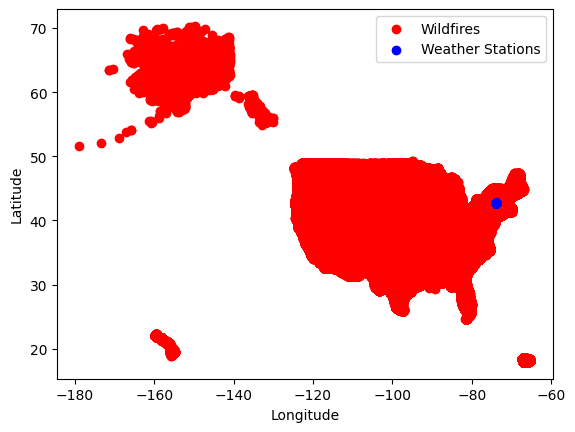

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(firefinal['LONGITUDE'], firefinal['LATITUDE'], color='red', label='Wildfires')
plt.scatter(precipitation2['LONGITUDE'], precipitation2['LATITUDE'], color='blue', label='Weather Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:
merged_df.head()

,FIRE_YEAR,DISCOVERY_DATE_x,FIRE_SIZE,LATITUDE,LONGITUDE,DailyAverageWindSpeed_x,DailyPrecipitation_x,DISCOVERY_DATE_y,DailyAverageWindSpeed_y,DailyPrecipitation_y
0,2005,2005-02-02,0.10,40.03694,-121.00583,9.5,0.0,NaT,NaN,NaN
1,2004,2004-05-12,0.25,38.93306,-120.40444,9.5,0.0,NaT,NaN,NaN
2,2004,2004-05-31,0.10,38.98417,-120.73556,9.5,0.0,NaT,NaN,NaN
3,2004,2004-06-28,0.10,38.55917,-119.91333,9.5,0.0,NaT,NaN,NaN
4,2004,2004-06-28,0.10,38.55917,-119.93306,9.5,0.0,NaT,NaN,NaN
